In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
from scipy.stats import linregress

import sys
sys.path.append("/home/z5297792/UNSW-MRes/MRes/modules") 
from utils import dopioe, compute_tilt_data, bearing, ellipse_aspect_ratio, phys_grad

df_eddies = pd.read_pickle('/srv/scratch/z5297792/Chapter2/SEACOFS_26yr_Eddy_Dataset/Eddy_Data/df_eddies_processed_1462_10650.pkl')

In [2]:
import netCDF4 as nc
from scipy.interpolate import griddata
import netCDF4 as nc
from scipy.interpolate import RegularGridInterpolator

# Field Data

fname = f'/srv/scratch/z3533156/26year_BRAN2020/outer_avg_01461.nc'

dataset = nc.Dataset(fname)

lon_rho = np.transpose(dataset.variables['lon_rho'], axes=(1, 0))
lat_rho = np.transpose(dataset.variables['lat_rho'], axes=(1, 0))
mask_rho = np.transpose(dataset.variables['mask_rho'], axes=(1, 0))
h = np.transpose(dataset.variables['h'], axes=(1, 0))
# f = np.transpose(dataset.variables['f'], axes=(1, 0))
angle = dataset.variables['angle'][0, 0]
z_r = np.load('/srv/scratch/z5297792/z_r.npy')
z_r = np.transpose(z_r, (1, 2, 0))

def distance(lat1, lon1, lat2, lon2):
    EARTH_RADIUS = 6357
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat, dlon = lat2 - lat1, lon2 - lon1
    a = np.sin(dlat/2)**2 + np.cos(lat1)*np.cos(lat2)*np.sin(dlon/2)**2
    return EARTH_RADIUS * 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))

j_mid = lon_rho.shape[1] // 2
i_mid = lon_rho.shape[0] // 2

dx = distance(lat_rho[:-1, j_mid], lon_rho[:-1, j_mid],
              lat_rho[1:, j_mid], lon_rho[1:, j_mid])
dy = distance(lat_rho[i_mid, :-1], lon_rho[i_mid, :-1],
              lat_rho[i_mid, 1:], lon_rho[i_mid, 1:])

x_grid = np.insert(np.cumsum(dx), 0, 0)
y_grid = np.insert(np.cumsum(dy), 0, 0)
X_grid, Y_grid = np.meshgrid(x_grid, y_grid, indexing='ij')


In [3]:
# with open('/srv/scratch/z5297792/Chapter2/SEACOFS_26yr_Eddy_Dataset/Eddy_Data/Vertical_Eddy_Dataset/dic_vert_eddies.pkl', 'rb') as f:
#     dic_eddies_vert = pickle.load(f)


In [4]:
# for e, eddy in enumerate(dic_eddies_vert.keys()):
#     dic = dic_eddies_vert[eddy]
#     df = compute_tilt_data(dic, int(eddy[4:]), num=6)
#     if e == 0:
#         df_tilt_data = df
#     else:
#         df_tilt_data = pd.concat([df_tilt_data, df], ignore_index=True)
# df_tilt_data.to_pickle("/srv/scratch/z5297792/Chapter2/SEACOFS_26yr_Eddy_Dataset/Eddy_Data/Vertical_Eddy_Dataset/df_tilt_data.pkl") 

df_tilt_data = pd.read_pickle("/srv/scratch/z5297792/Chapter2/SEACOFS_26yr_Eddy_Dataset/Eddy_Data/Vertical_Eddy_Dataset/df_tilt_data.pkl")
df_eddies = df_eddies.merge(
    df_tilt_data[['Eddy', 'Day', 'TiltDis', 'TiltDir']],
    how='left',
    left_on=['Eddy', 'Day'],
    right_on=['Eddy', 'Day']
)
df_eddies


,Eddy,Day,Cyc,Lon,Lat,ic,jc,xc,yc,w,...,q22,Rc,psi0,A,R,Age,Date,fname,TiltDis,TiltDir
0,1,1462,CE,156.969773,-28.461100,179,274,505.897600,1353.012251,-0.000033,...,0.943344,104.677927,71.391686,-0.006515,69.250036,57,1994-01-02,/srv/scratch/z3533156/26year_BRAN2020/outer_av...,NaN,NaN
1,1,1463,CE,156.993096,-28.433992,179,275,507.149717,1356.633687,-0.000030,...,0.950849,110.542281,77.351002,-0.006330,62.000626,57,1994-01-03,/srv/scratch/z3533156/26year_BRAN2020/outer_av...,NaN,NaN
2,1,1464,CE,157.097940,-28.381485,181,276,515.130000,1365.650728,-0.000028,...,1.006892,115.245476,75.250400,-0.005666,67.000485,57,1994-01-04,/srv/scratch/z3533156/26year_BRAN2020/outer_av...,NaN,NaN
3,1,1465,CE,157.094334,-28.315658,181,278,512.570772,1372.426342,-0.000033,...,1.200119,114.738549,72.789618,-0.005529,66.501582,57,1994-01-05,/srv/scratch/z3533156/26year_BRAN2020/outer_av...,31.669332,89.546110
4,1,1466,CE,157.106324,-28.346479,181,277,514.728351,1369.599726,-0.000029,...,1.214160,100.425496,58.705551,-0.005821,56.251116,57,1994-01-06,/srv/scratch/z3533156/26year_BRAN2020/outer_av...,33.600109,92.955602
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105233,2631,10646,AE,157.825620,-37.030656,248,97,850.502045,476.447416,0.000013,...,1.156400,114.894173,-41.491437,0.003143,72.751791,24,2019-02-24,/srv/scratch/z3533156/26year_BRAN2020/outer_av...,12.848125,334.097803
105234,2631,10647,AE,157.880796,-36.972725,249,98,853.608024,484.316677,0.000014,...,1.238286,111.853372,-42.195517,0.003373,73.000933,24,2019-02-25,/srv/scratch/z3533156/26year_BRAN2020/outer_av...,13.627106,324.784689
105235,2631,10648,AE,157.868516,-36.874363,248,100,849.759258,494.400614,0.000014,...,1.163994,107.180060,-43.102690,0.003752,75.750780,24,2019-02-26,/srv/scratch/z3533156/26year_BRAN2020/outer_av...,NaN,NaN
105236,2631,10649,AE,157.753058,-36.882303,246,99,840.037603,489.981707,0.000013,...,1.203104,100.368133,-37.967048,0.003769,75.750006,24,2019-02-27,/srv/scratch/z3533156/26year_BRAN2020/outer_av...,NaN,NaN


In [5]:
num_profiles = len(df_eddies)-6*len(df_eddies.Eddy.unique())
print(f'Total No. of used profiles: {num_profiles}')
num_tilt_profiles = np.sum(~np.isnan(df_eddies.TiltDis))
print(f'Total No. of profiles tilt measured: {num_tilt_profiles}')
print(f'Tilt measuring success rate: {num_tilt_profiles/num_profiles*100:.2f}%')


Total No. of used profiles: 89452
Total No. of profiles tilt measured: 74927
Tilt measuring success rate: 83.76%


In [6]:
df_tilt_data_clean = df_tilt_data.dropna().copy()
percent_prof_TD_blw_40 = np.sum(df_tilt_data_clean.TiltDis <= 40) / num_tilt_profiles
print(f'% Profiles below 40km TD: {percent_prof_TD_blw_40*100:.2f}%')
print(f'Max TD {df_tilt_data_clean.TiltDis.max():.0f}')


% Profiles below 40km TD: 85.48%
Max TD 152


In [7]:
# sample tilt sanity check
queries = {
    66: 26,
    425: 17,
    871: 5,
    1780: 51,
    31: 68,
    182: 89,
    1602: 114,
    2128: 40
}
rows = []
for eddy, offset in queries.items():
    df_eddy = df_eddies[df_eddies.Eddy == eddy]
    target_day = df_eddy.Day.iloc[0] + offset
    df_row = df_eddy[df_eddy.Day == target_day][["Eddy","TiltDis","TiltDir"]]
    rows.append(df_row)
df_print = pd.concat(rows)
df_print


,Eddy,TiltDis,TiltDir
2948,66,28.796203,340.260311
17380,425,5.543649,359.981910
35345,871,12.767714,328.620923
71635,1780,19.476659,36.319065
1311,31,NaN,NaN
7743,182,18.527909,132.390564
64574,1602,6.382550,160.930798
85942,2128,10.491482,244.676908


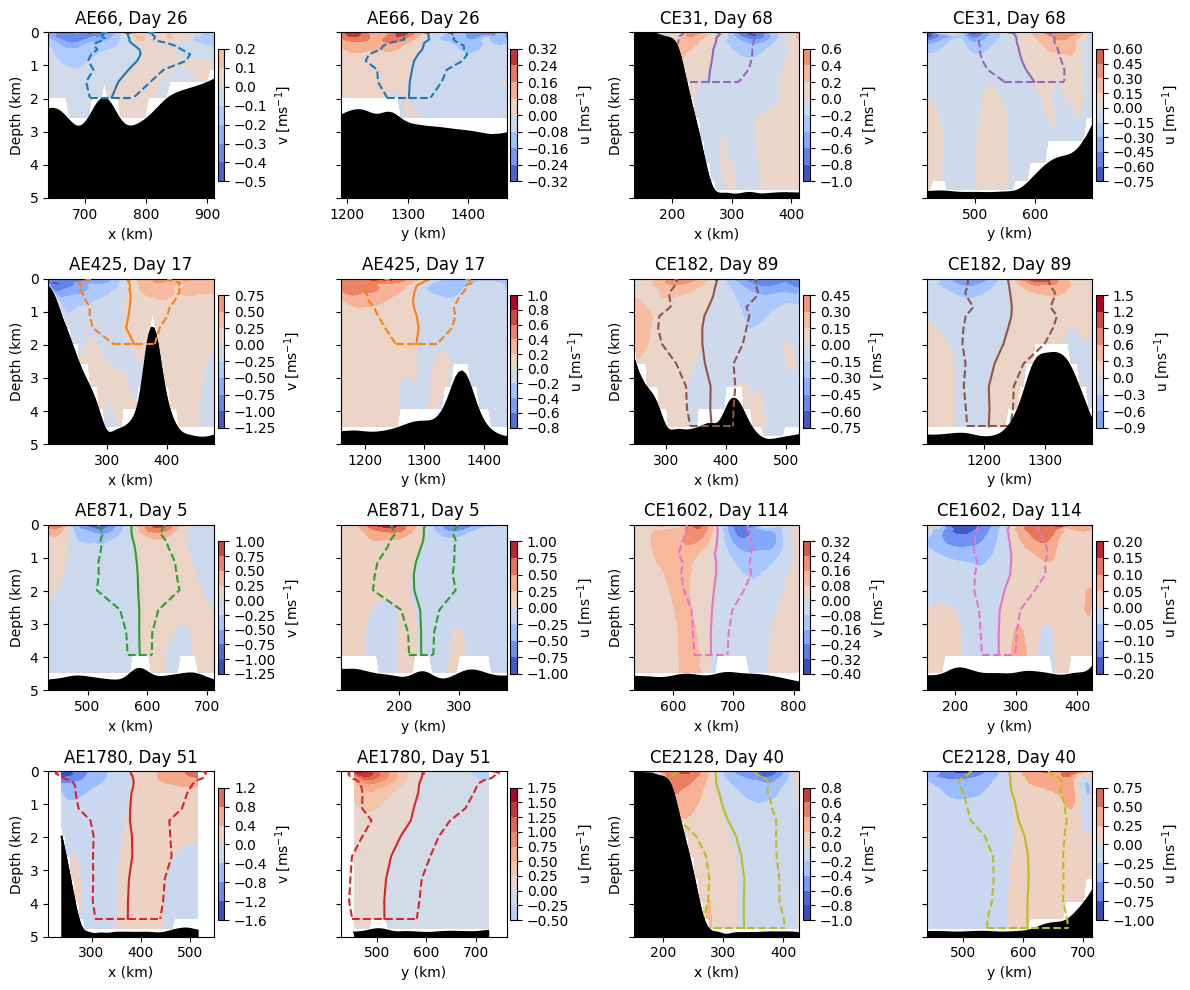


#### Additional Data

In [8]:
def compute_core_mean(
    df_eddies,
    X_grid,
    Y_grid,
    mask_rho,
    base_path=None,
    varname=None,
    fixed_field=None,
    colname=None,
):
    """
    Core-mean of either
      - a 3D field (x,y,t) loaded as <varname>_<fnumber>.npy, or
      - a fixed 2D field (x,y) passed in as fixed_field.
    """
    if fixed_field is None and (base_path is None or varname is None):
        raise ValueError("Either fixed_field OR (base_path and varname) must be provided.")
    mode_2d = fixed_field is not None
    if colname is None:
        if mode_2d:
            colname = "field_core"
        else:
            colname = f"{varname}"
    df = df_eddies[~df_eddies["TiltDis"].isna()].copy()
    chunks = []
    if mode_2d:
        field2d = np.where(mask_rho, fixed_field, np.nan)
    for fname, df_loc in df.groupby("fname"):
        if not mode_2d:
            fnumber  = int(fname[-8:-3])
            base_day = fnumber + 1
            data3d = np.load(f"{base_path}/{varname}_{fnumber:05}.npy")
            data3d = np.where(mask_rho[:, :, None], data3d, np.nan)
        df_loc = df_loc.copy().reset_index(drop=False)
        core_vals = np.full(len(df_loc), np.nan)
        for idx, row in enumerate(df_loc.itertuples(index=False)):
            dx = X_grid - row.xc
            dy = Y_grid - row.yc
            rho2 = (
                row.q11 * dx**2
                + 2 * row.q12 * dx * dy
                + row.q22 * dy**2
            )
            core_mask = rho2 <= row.Rc**2 / 2
            if not core_mask.any():
                continue
            if mode_2d:
                vals = field2d[core_mask]
            else:
                t_idx = int(row.Day - base_day)
                vals = data3d[:, :, t_idx][core_mask]
            core_vals[idx] = np.nanmean(vals)
        chunks.append(pd.DataFrame({
            "Eddy": df_loc["Eddy"].to_numpy(),
            "Day":  df_loc["Day"].to_numpy(),
            colname: core_vals
        }))
    df_core = pd.concat(chunks, ignore_index=True)
    df_out = df_eddies.merge(
        df_core[["Eddy", "Day", colname]],
        how="left",
        on=["Eddy", "Day"]
    )
    return df_out


In [9]:
# # Eddy Propogation Speed
# eddy_props = []
# for eddy in df_eddies.Eddy.unique():
#     df = df_eddies[df_eddies.Eddy==eddy].copy()
#     eddy_props.extend(np.array(np.hypot(df.xc.diff(), df.yc.diff()) * 0.011574))
# df_eddies['EddyProp'] = eddy_props

# # displacement of top center
# dxs, dys = [], []
# for eddy in df_eddies.Eddy.unique():
#     df = df_eddies[df_eddies.Eddy==eddy].copy()
#     dxs.extend(df.xc.diff())
#     dys.extend(df.yc.diff())
# df_eddies['dx_top'] = dxs
# df_eddies['dy_top'] = dys

# # bottom of eddy propogation
# df_idx = df_eddies.set_index(['Eddy', 'Day'])
# eddy_btm_prop = []
# for eddy, dic in dic_eddies_vert.items():
#     x_btms, y_btms = [], []
#     eddy_id = int(eddy[4:])
#     for day, df in dic.items():
#         if len(df):
#             df = df.copy()
#             df = df[df.Depth.abs() < 1000]
#             data = df.iloc[-1]
#             xc, yc = data.x, data.y
#         else:
#             day_id = int(day[3:])
#             data = df_idx.loc[(eddy_id, day_id)]
#             xc, yc = data.xc, data.yc
#         x_btms.append(xc)
#         y_btms.append(yc)
#     disp = np.hypot(np.diff(x_btms), np.diff(y_btms)) * 0.011574
#     disp = np.insert(disp, 0, np.nan)   # add NaN at the start
#     eddy_btm_prop.extend(disp)
# df_eddies['btm_prop'] = eddy_btm_prop

# # displacement of bottom center
# df_idx = df_eddies.set_index(['Eddy', 'Day'])
# dxs, dys = [], []
# for eddy, dic in dic_eddies_vert.items():
#     x_btms, y_btms = [], []
#     eddy_id = int(eddy[4:])
#     for day, df in dic.items():
#         if len(df):
#             df = df.copy()
#             df = df[df.Depth.abs() < 1000]
#             data = df.iloc[-1]
#             xc, yc = data.x, data.y
#         else:
#             day_id = int(day[3:])
#             data = df_idx.loc[(eddy_id, day_id)]
#             xc, yc = data.xc, data.yc
#         x_btms.append(xc)
#         y_btms.append(yc)
#     dx = np.diff(x_btms)
#     dy = np.diff(y_btms)
#     dx = np.insert(dx, 0, np.nan)  
#     dy = np.insert(dy, 0, np.nan) 
#     dxs.extend(dx)
#     dys.extend(dy)
# df_eddies['dx_btm'] = dxs
# df_eddies['dy_btm'] = dys

# # vector difference between top and bottom m/s
# df_eddies['top_btm_diff'] = np.hypot(df_eddies.dx_btm - df_eddies.dx_top,
#                                      df_eddies.dy_btm - df_eddies.dy_top)  * 0.011574


In [10]:
# # Lifespan Day Index
# day_idxs = []
# for eddy in df_eddies.Eddy.unique():
#     df = df_eddies[df_eddies.Eddy==eddy].copy()
#     if len(df):
#         day_idxs.extend(df.Day-df.Day.iloc[0])
# df_eddies['Day_idx'] = day_idxs

# # Dimensionless Time
# norm_time = []
# for eddy in df_eddies.Eddy.unique():
#     seg = df_eddies[df_eddies.Eddy == eddy]
#     n = len(seg)
#     norm_time.extend(np.arange(n) / n)
# df_eddies['norm_time'] = norm_time

# # Aspect Ratio
# ARs = []
# for k in range(len(df_eddies)):
#     data = df_eddies.iloc[k]
#     ARs.append(ellipse_aspect_ratio(data.q11, data.q12, data.q22))
# df_eddies['AR'] = ARs

# Batheymetry averaged about the core
# df_eddies = compute_core_mean(
#     df_eddies,
#     X_grid, Y_grid,
#     mask_rho,
#     fixed_field=h,
#     colname="h"
# )
df_eddies['h'] = h[df_eddies.ic, df_eddies.jc]

# Coriolis
f = np.transpose(dataset.variables['f'], axes=(1, 0))
df_eddies['f'] = f[df_eddies.ic, df_eddies.jc]

# # Rossby Number
# df_eddies['Ro'] = df_eddies.w / df_eddies.f

# # Potential Vorticity
# df_eddies['PV'] = (df_eddies.w + df_eddies.f) / df_eddies.h

# # Nbar
# df_eddies = compute_core_mean(
#     df_eddies,
#     X_grid, Y_grid,
#     mask_rho,
#     base_path="/srv/scratch/z5297792/Climatology/N2s/Nbars_300m_depth",
#     varname="Nbar",
#     colname="Nbar"
# )

# Slope Magntiude
dhdx, dhdy = phys_grad(h, X_grid*1e3, Y_grid*1e3, mask_rho)    # IS W.R.T THE GRID !!!!
s = np.hypot(dhdx, dhdy)
df_eddies['s'] = s[df_eddies.ic, df_eddies.jc]

# topographic beta
dh_dTN = - (np.sin(angle) * dhdx + np.cos(angle) * dhdy)
beta_topo = -f * dh_dTN / h**2
df_eddies['top_beta'] = -df_eddies.f * dh_dTN[df_eddies.ic, df_eddies.jc] / df_eddies.h**2
df_eddies['top_beta_abs'] = df_eddies.top_beta.abs()

# planetary beta
dfdx, dfdy = phys_grad(f, X_grid*1e3, Y_grid*1e3, mask_rho)
df_dTN = - (np.sin(angle) * dfdx + np.cos(angle) * dfdy)
beta_plan = df_dTN / h
df_eddies['plan_beta'] = beta_plan[df_eddies.ic, df_eddies.jc]
df_eddies['plan_beta_abs'] = df_eddies.plan_beta.abs()

# Beta
df_eddies['beta'] = (df_eddies.top_beta + df_eddies.plan_beta).abs()

# AE CE DataFrames
df_AE = df_eddies[df_eddies.Cyc=='AE'].copy()
df_CE = df_eddies[df_eddies.Cyc=='CE'].copy()
df_AE_ = df_eddies[df_eddies.Cyc=='AE'].copy()
df_AE_ = df_AE_[~df_AE_.TiltDis.isna()]
df_CE_ = df_eddies[df_eddies.Cyc=='CE'].copy()
df_CE_ = df_CE_[~df_CE_.TiltDis.isna()]

print(f'AE TD Mean: {round(df_AE.TiltDis.mean())}km')
print(f'CE TD Mean: {round(df_CE.TiltDis.mean())}km')


AE TD Mean: 24km
CE TD Mean: 21km


### Latitude Analysis

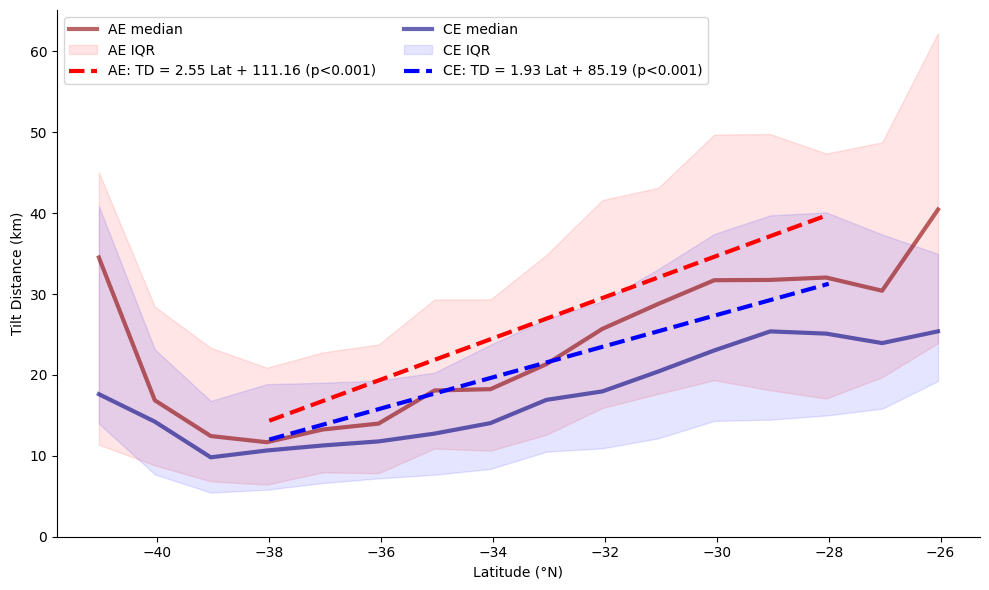

In [11]:
fig, ax = plt.subplots(figsize=(10, 6))
styles = {
    'AE': {'line': 'darkred', 'fill': 'red'},
    'CE': {'line': 'navy',    'fill': 'blue'}
}

bins = np.arange(lat_rho.min(), lat_rho.max(), 1)
bin_centers = .5 * (bins[:-1] + bins[1:])

for cyc in ['AE', 'CE']:
    df_masked = df_eddies[df_eddies.Cyc == cyc].copy()
    df_masked = df_masked.dropna(subset=['Lat', 'TiltDis'])

    tilt = df_masked['TiltDis']
    lat  = df_masked['Lat']
    
    digitized = np.digitize(lat, bins)
    median = [tilt[digitized == i].median()        for i in range(1, len(bins))]
    q25    = [tilt[digitized == i].quantile(0.25)  for i in range(1, len(bins))]
    q75    = [tilt[digitized == i].quantile(0.75)  for i in range(1, len(bins))]

    # median + IQR (all data)
    ax.plot(bin_centers, median, color=styles[cyc]['line'], lw=3, label=f'{cyc} median', alpha=.6)
    ax.fill_between(
        bin_centers,
        q25, q75,
        color=styles[cyc]['fill'],
        alpha=0.1,
        label=f'{cyc} IQR'
    )

    # ---- regression ----
    reg_mask = (lat <= -28) & (lat >= -38)
    lat_reg  = lat[reg_mask]
    tilt_reg = tilt[reg_mask]

    if len(lat_reg) > 1:
        slope, intercept, r_value, p_value, std_err = linregress(lat_reg.values, tilt_reg.values)

        lat_line  = np.linspace(lat_reg.min(), lat_reg.max(), 100)
        tilt_line = slope * lat_line + intercept

        m, c = slope, intercept
        if c >= 0:
            eq_str = f'TD = {m:.2f} Lat + {c:.2f}'
        else:
            eq_str = f'TD = {m:.2f} Lat - {abs(c):.2f}'

        p_str = 'p<0.001' if p_value < 0.001 else f'p = {p_value:.3f}'

        ax.plot(
            lat_line,
            tilt_line,
            lw=3,
            color=styles[cyc]['fill'],
            linestyle='--',
            label=f'{cyc}: {eq_str} ({p_str})'
        )

ax.set_ylim(0, None)
ax.set_xlabel(r'Latitude (°N)')
ax.set_ylabel('Tilt Distance (km)')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.legend(loc='upper left', ncol=2)
# ax.grid(True)
plt.tight_layout()
plt.show()


Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


Min/max tilt per bin:
2.9187645906182667 80.6132795519723
Min/max tilt per bin:
2.4408973993907153 103.98748080346913


Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


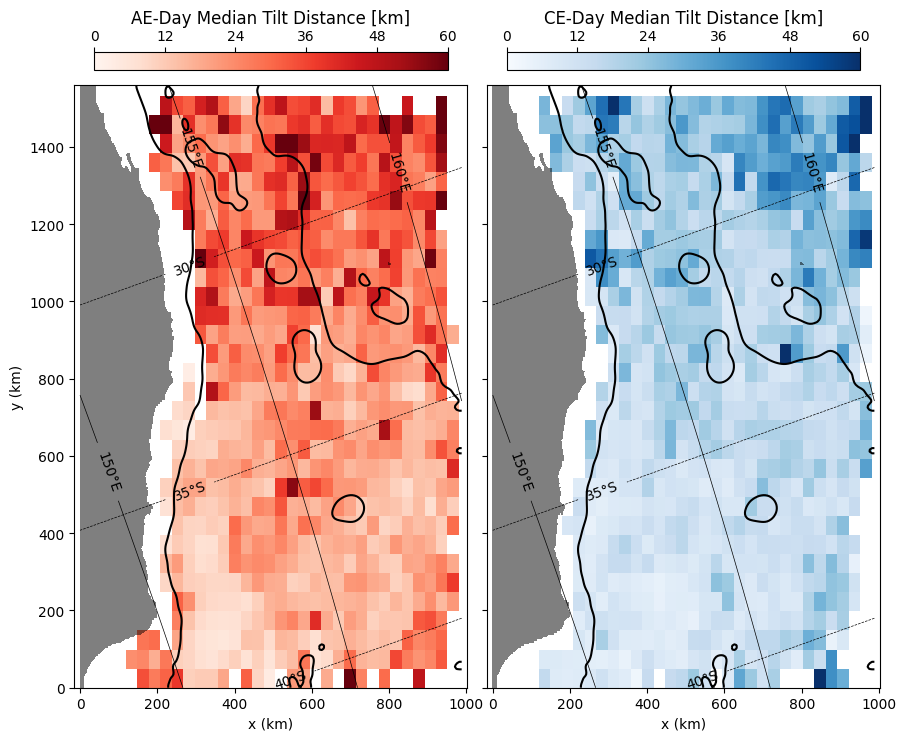

Unique Δx: [29.73256356]
Unique Δy: [49.42377476]
Number of x-bins: 30
Number of y-bins: 31


In [12]:
def _nice_step(h, base):
    s = h / base
    for k in [1, 2, 2.5, 5, 10]:
        if s <= k: 
            return k * base
    return np.ceil(s) * base

def _grid_step(G):
    gx = np.diff(np.sort(np.unique(G.ravel())))
    return np.nanmedian(gx[gx > 0])

def _bin_edges_fd(x, grid, scale=1.0, rule='fd'):
    x = np.asarray(x)
    x = x[np.isfinite(x)]
    n = len(x)
    if n < 2:
        lo, hi = np.nanmin(x), np.nanmax(x)
        return np.array([lo, hi])

    iqr = np.subtract(*np.percentile(x, [75, 25]))
    std = np.std(x, ddof=1)

    if rule.lower() == 'fd':
        bw = 2 * (iqr if iqr > 0 else 1.349 * std) / (n ** (1/3))
    else:
        bw = 3.5 * std / (n ** (1/3))

    if not np.isfinite(bw) or bw <= 0:
        rng = np.ptp(x)
        bw = rng / max(10, np.sqrt(n))

    base = _grid_step(grid)
    bw = _nice_step(scale * bw, base)

    lo = np.floor(np.nanmin(x) / bw) * bw
    hi = np.ceil(np.nanmax(x) / bw) * bw
    return np.arange(lo, hi + bw, bw)

xbins = _bin_edges_fd(df_eddies.xc.values, X_grid, scale=1.0, rule='fd')
ybins = _bin_edges_fd(df_eddies.yc.values, Y_grid, scale=1.0, rule='fd')

vmin, vmax = 0, 60
levels_lat = [-40, -35, -30, -25]
levels_lon = [150, 155, 160]

from matplotlib.colors import Normalize
norm = Normalize(vmin=vmin, vmax=vmax)
cmaps = {"AE-Day": "Reds", "CE-Day": "Blues"}

def binned_median(x, y, v, xbins, ybins):
    ix = np.digitize(x, xbins) - 1
    iy = np.digitize(y, ybins) - 1
    nx, ny = len(xbins) - 1, len(ybins) - 1
    ok = (ix >= 0) & (ix < nx) & (iy >= 0) & (iy < ny) & np.isfinite(v)

    ix, iy, v = ix[ok], iy[ok], v[ok]
    flat = iy * nx + ix

    hmed = np.full(nx * ny, np.nan)
    for k in np.unique(flat):
        hmed[k] = np.nanmedian(v[flat == k])

    return hmed.reshape(ny, nx)

fig, axs = plt.subplots(1, 2, figsize=(9, 8), sharey=True)

for ax, cyc in zip(axs, ['AE-Day', 'CE-Day']):
    df = df_eddies[df_eddies.Cyc == cyc[:2]].copy()
    df = df.sort_values('TiltDis', kind='mergesort', ignore_index=True)

    ax.contour(X_grid, Y_grid, h, levels=[4000], colors='k')

    H = binned_median(df.xc.values, df.yc.values, df.TiltDis.values, xbins, ybins)
    print("Min/max tilt per bin:")
    print(np.nanmin(H), np.nanmax(H))
    m = ax.pcolormesh(xbins, ybins, H, cmap=cmaps[cyc], norm=norm,
                      shading='auto', rasterized=True)
    cb = fig.colorbar(m, ax=ax, location='top', shrink=0.9, pad=0.02)
    cb.set_label(f'{cyc} Median Tilt Distance [km]', fontsize=12)
    cb.set_ticks(np.linspace(vmin, vmax, 6))

    ax.contourf(X_grid, Y_grid, np.where(mask_rho == 0, 1, np.nan),
                levels=[0.5, 1.5], colors=['k'], alpha=.5)

    c1 = ax.contour(X_grid, Y_grid, lat_rho, levels=levels_lat,
                    colors='k', linewidths=.5)
    ax.clabel(c1, fmt=lambda v: f"{-v:.0f}°S", inline=True, colors='k')
    c2 = ax.contour(X_grid, Y_grid, lon_rho, levels=levels_lon,
                    colors='k', linewidths=.5)
    ax.clabel(c2, fmt=lambda v: f"{v:.0f}°E", inline=True, colors='k')

    ax.axis('equal')
    ax.set_xlim(X_grid.min(), X_grid.max())
    ax.set_ylim(Y_grid.min(), Y_grid.max())

for ax in axs:
    ax.set_xlabel('x (km)')
axs[0].set_ylabel('y (km)')

plt.tight_layout()
plt.show()

dx = np.diff(xbins)
dy = np.diff(ybins)

print("Unique Δx:", np.unique(dx))
print("Unique Δy:", np.unique(dy))
print("Number of x-bins:", len(dx))
print("Number of y-bins:", len(dy))



#### $\bar{N}$

In [13]:
# fig, ax = plt.subplots(figsize=(10, 5))

# styles = {
#     'AE': {'line': 'darkred',  'fill': 'red'},
#     'CE': {'line': 'navy',     'fill': 'blue'}
# }

# # ------------------------------------------------------------
# # Build quantile-based bins using ALL Nbar > 0
# # ------------------------------------------------------------
# df_all = df_eddies.copy()
# df_all = df_all.dropna(subset=['Nbar'])
# N_all = df_all.Nbar.values

# nbins = 30
# bins = np.quantile(N_all, np.linspace(0, 1, nbins + 1))
# bins = np.unique(bins)
# bin_centers = 0.5 * (bins[:-1] + bins[1:])

# # ------------------------------------------------------------
# # MAIN PLOT
# # ------------------------------------------------------------
# for cyc in ['AE', 'CE']:

#     df_masked = df_eddies[df_eddies.Cyc == cyc].copy()
#     df_masked = df_masked.dropna(subset=['Nbar', 'TiltDis'])

#     xval = df_masked['Nbar'].values
#     tilt = df_masked['TiltDis'].values

#     # bin everything — no masking whatsoever
#     digitized = np.digitize(xval, bins)
#     median = [np.nanmedian(tilt[digitized == i]) for i in range(1, len(bins))]
#     q25    = [np.nanquantile(tilt[digitized == i], .25) for i in range(1, len(bins))]
#     q75    = [np.nanquantile(tilt[digitized == i], .75) for i in range(1, len(bins))]

#     # ax.scatter(xval, tilt, s=1, alpha=0.08, marker='.',
#     #        color=styles[cyc]['fill'])    

#     ax.plot(bin_centers, median, lw=3, color=styles[cyc]['line'],
#             alpha=.6, label=f'{cyc} median')

#     ax.fill_between(bin_centers, q25, q75,
#                     color=styles[cyc]['fill'], alpha=0.10, label=f'{cyc} IQR')

#     # ------------------------------------------------------------
#     # Linear regression on a chosen interval of Nbar
#     # (keep this if you want restricted-slope fitting)
#     # ------------------------------------------------------------
#     # Nmin, Nmax = np.nanpercentile(N_all, [10, 90])
#     Nmin, Nmax = bin_centers.min(), bin_centers.max()
#     mask_reg = (xval >= Nmin) & (xval <= Nmax)

#     if mask_reg.sum() > 2:
#         xr = xval[mask_reg]
#         yr = tilt[mask_reg]

#         m, c, r, p, se = linregress(xr, yr)

#         x_fit = np.linspace(Nmin, Nmax, 200)
#         y_fit = m * x_fit + c

#         ax.plot(x_fit, y_fit, '--', lw=3, color=styles[cyc]['fill'],
#                 label=f'{cyc}: TD={m:.2e} N̄ + {c:.2f}')

# # ------------------------------------------------------------
# # Formatting
# # ------------------------------------------------------------
# # ax.set_xlim(N_all.min(), N_all.max())
# ax.set_xlim(.007, .01)
# # ax.set_ylim(0, np.nanmax(df_eddies.TiltDis) * 1.1)
# ax.set_ylim(0, 50)
# ax.set_xlabel(r'$\overline{N}$ (s$^{-1}$)')
# ax.set_ylabel('Tilt Distance (km)')
# ax.spines['top'].set_visible(False)
# ax.spines['right'].set_visible(False)
# ax.legend(loc='upper left', ncol=2)

# plt.tight_layout()
# plt.show()



Nbar tells us how strongly the water column is stratified\
Large Nbar $\rightarrow$ strong stratifcation\
small Nbar $\rightarrow$ weak straifcation\
Nbar $\approx 0 \rightarrow$ well-mixed water


/home/z5297792/myenv310/lib/python3.10/site-packages/numpy/lib/_function_base_impl.py:4842: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(


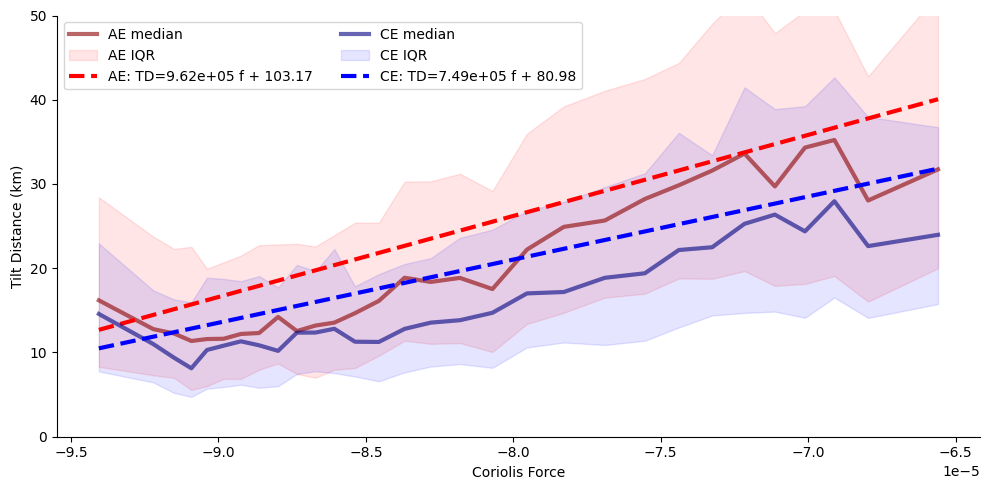

In [14]:
fig, ax = plt.subplots(figsize=(10, 5))

styles = {
    'AE': {'line': 'darkred',  'fill': 'red'},
    'CE': {'line': 'navy',     'fill': 'blue'}
}

# ------------------------------------------------------------
# Build quantile-based bins using ALL 
# ------------------------------------------------------------
df_all = df_eddies.copy()
df_all = df_all.dropna(subset=['f'])
N_all = df_all.f.values

nbins = 30
bins = np.quantile(N_all, np.linspace(0, 1, nbins + 1))
bins = np.unique(bins)
bin_centers = 0.5 * (bins[:-1] + bins[1:])

# ------------------------------------------------------------
# MAIN PLOT
# ------------------------------------------------------------
for cyc in ['AE', 'CE']:

    df_masked = df_eddies[df_eddies.Cyc == cyc].copy()
    df_masked = df_masked.dropna(subset=['f', 'TiltDis'])

    xval = df_masked['f'].values
    tilt = df_masked['TiltDis'].values

    # bin everything — no masking whatsoever
    digitized = np.digitize(xval, bins)

    median = [np.nanmedian(tilt[digitized == i]) for i in range(1, len(bins))]
    q25    = [np.nanquantile(tilt[digitized == i], .25) for i in range(1, len(bins))]
    q75    = [np.nanquantile(tilt[digitized == i], .75) for i in range(1, len(bins))]

    # ax.scatter(xval, tilt, s=1, alpha=0.08, marker='.',
    #        color=styles[cyc]['fill'])    

    ax.plot(bin_centers, median, lw=3, color=styles[cyc]['line'],
            alpha=.6, label=f'{cyc} median')

    ax.fill_between(bin_centers, q25, q75,
                    color=styles[cyc]['fill'], alpha=0.10, label=f'{cyc} IQR')

    # ------------------------------------------------------------
    # Linear regression on a chosen interval of xval
    # (keep this if you want restricted-slope fitting)
    # ------------------------------------------------------------
    # Nmin, Nmax = np.nanpercentile(N_all, [10, 90])
    Nmin, Nmax = bin_centers.min(), bin_centers.max()
    mask_reg = (xval >= Nmin) & (xval <= Nmax)

    if mask_reg.sum() > 2:
        xr = xval[mask_reg]
        yr = tilt[mask_reg]

        m, c, r, p, se = linregress(xr, yr)

        x_fit = np.linspace(Nmin, Nmax, 200)
        y_fit = m * x_fit + c

        ax.plot(x_fit, y_fit, '--', lw=3, color=styles[cyc]['fill'],
                label=f'{cyc}: TD={m:.2e} f + {c:.2f}')

# ------------------------------------------------------------
# Formatting
# ------------------------------------------------------------
ax.set_ylim(0, 50)
ax.set_xlabel(r'Coriolis Force')
ax.set_ylabel('Tilt Distance (km)')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.legend(loc='upper left', ncol=2)

plt.tight_layout()
plt.show()


### $\beta$

In [61]:
def beta_panel_2x3(xcap1_min=None, xcap1_max=None,
                   xcap2_min=None, xcap2_max=None,
                   xcap3_min=None, xcap3_max=None,
                   scatter=False, abs_vals=True, ylim=None,
                   sharey=True, linfit=True):
    fig, axs = plt.subplots(2, 3, figsize=(14, 8), sharey=sharey)
    ax0, ax1, ax2 = axs[0, 0], axs[0, 1], axs[0, 2]
    ax3, ax4, ax5 = axs[1, 0], axs[1, 1], axs[1, 2]
    
    styles = {
        'AE': {'line': 'darkred',  'fill': 'red'},
        'CE': {'line': 'navy',     'fill': 'blue'}
    }
    
    # ------------------------------------------------------------
    # TOP ROW: beta–TiltDis panels (your beta_plotter)
    # ------------------------------------------------------------
    # PANEL 1: Planetary beta
    df_all = df_eddies.copy()
    df_all = df_all[(df_all.plan_beta_abs >= xcap1_min) & (df_all.plan_beta_abs <= xcap1_max)]
    if abs_vals:
        df_all = df_all.dropna(subset=['plan_beta_abs'])
        N_all = df_all.plan_beta_abs.values
    else:
        df_all = df_all.dropna(subset=['plan_beta'])
        N_all = df_all.plan_beta.values
    
    nbins = 30
    bins = np.quantile(N_all, np.linspace(0, 1, nbins + 1))
    bins = np.unique(bins)
    bin_centers = 0.5 * (bins[:-1] + bins[1:])
    Nmin1, Nmax1 = bin_centers.min(), bin_centers.max()
    
    for cyc in ['AE', 'CE']:
        df_masked = df_eddies[df_eddies.Cyc == cyc].copy()
        df_masked = df_masked[(df_masked.plan_beta_abs >= xcap1_min) & (df_masked.plan_beta_abs <= xcap1_max)]
        if abs_vals:
            df_masked = df_masked.dropna(subset=['plan_beta_abs', 'TiltDis'])
            xval = df_masked['plan_beta_abs'].values
        else:
            df_masked = df_masked.dropna(subset=['plan_beta', 'TiltDis'])
            xval = df_masked['plan_beta'].values
        tilt = df_masked['TiltDis'].values
    
        digitized = np.digitize(xval, bins)
        median = [np.nanmedian(tilt[digitized == i]) for i in range(1, len(bins))]
        q25    = [np.nanquantile(tilt[digitized == i], .25) for i in range(1, len(bins))]
        q75    = [np.nanquantile(tilt[digitized == i], .75) for i in range(1, len(bins))]
        if scatter:
            ax0.scatter(xval, tilt, s=1, alpha=0.08, marker='.',
                        color=styles[cyc]['fill'])    
    
        ax0.plot(bin_centers, median, lw=3, color=styles[cyc]['line'],
                 alpha=.6, label=f'{cyc} median')
        ax0.fill_between(bin_centers, q25, q75,
                         color=styles[cyc]['fill'], alpha=0.10, label=f'{cyc} IQR')
        if linfit:
            mask_reg = (xval >= Nmin1) & (xval <= Nmax1)
            if mask_reg.sum() > 2:
                xr, yr = xval[mask_reg], tilt[mask_reg]
                m, c, r, p, se = linregress(xr, yr)
                x_fit = np.linspace(Nmin1, Nmax1, 200)
                y_fit = m * x_fit + c
                ax0.plot(x_fit, y_fit, '--', lw=2, color=styles[cyc]['fill'],
                         label=f'{cyc} fit')

    ax0.set_xlim(xcap1_min, xcap1_max)
    if ylim is not None:
        ax0.set_ylim(0, ylim)
    ax0.set_xlabel(r'Planetary Beta $\beta=|\frac{1}{h}\ \frac{df}{dy}|$')
    ax0.set_ylabel('Tilt Distance (km)')
    ax0.spines['top'].set_visible(False)
    ax0.spines['right'].set_visible(False)
    
    # PANEL 2: |Topographic beta|
    df_all = df_eddies.copy()
    df_all = df_all[(df_all.top_beta_abs >= xcap2_min) & (df_all.top_beta_abs <= xcap2_max)]
    if abs_vals:
        df_all = df_all.dropna(subset=['top_beta_abs'])
        N_all = df_all.top_beta_abs.values
    else:
        df_all = df_all.dropna(subset=['top_beta'])
        N_all = df_all.top_beta.values
    
    nbins = 30
    bins = np.quantile(N_all, np.linspace(0, 1, nbins + 1))
    bins = np.unique(bins)
    bin_centers = 0.5 * (bins[:-1] + bins[1:])
    Nmin2, Nmax2 = bin_centers.min(), bin_centers.max()
    
    for cyc in ['AE', 'CE']:
        df_masked = df_eddies[df_eddies.Cyc == cyc].copy()
        df_masked = df_masked[(df_masked.top_beta_abs >= xcap2_min) & (df_masked.top_beta_abs <= xcap2_max)]
        if abs_vals:
            df_masked = df_masked.dropna(subset=['top_beta_abs', 'TiltDis'])
            xval = df_masked['top_beta_abs'].values
        else:
            df_masked = df_masked.dropna(subset=['top_beta', 'TiltDis'])
            xval = df_masked['top_beta'].values
        tilt = df_masked['TiltDis'].values
    
        digitized = np.digitize(xval, bins)
        median = [np.nanmedian(tilt[digitized == i]) for i in range(1, len(bins))]
        q25    = [np.nanquantile(tilt[digitized == i], .25) for i in range(1, len(bins))]
        q75    = [np.nanquantile(tilt[digitized == i], .75) for i in range(1, len(bins))]
        if scatter:
            ax1.scatter(xval, tilt, s=1, alpha=0.08, marker='.',
                        color=styles[cyc]['fill'])    
        
        ax1.plot(bin_centers, median, lw=3, color=styles[cyc]['line'],
                 alpha=.6, label=f'{cyc} median')
        ax1.fill_between(bin_centers, q25, q75,
                         color=styles[cyc]['fill'], alpha=0.10, label=f'{cyc} IQR')
        if linfit:
            mask_reg = (xval >= Nmin2) & (xval <= Nmax2)
            if mask_reg.sum() > 2:
                xr, yr = xval[mask_reg], tilt[mask_reg]
                m, c, r, p, se = linregress(xr, yr)
                x_fit = np.linspace(Nmin2, Nmax2, 200)
                y_fit = m * x_fit + c
                ax1.plot(x_fit, y_fit, '--', lw=2, color=styles[cyc]['fill'],
                         label=f'{cyc} fit')
    
    ax1.set_xlim(xcap2_min, xcap2_max)
    if ylim is not None:
        ax1.set_ylim(0, ylim)
    ax1.set_xlabel(r'Topographic Beta $\beta=|-\frac{f}{h^2}\ \frac{dh}{dy}|$')
    ax1.set_ylabel('Tilt Distance (km)')
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)
    
    # PANEL 3: Total beta
    df_all = df_eddies.copy()
    df_all = df_all[(df_all.beta >= xcap3_min) & (df_all.beta <= xcap3_max)]
    df_all = df_all.dropna(subset=['beta'])
    N_all = df_all.beta.values
    
    nbins = 30
    bins = np.quantile(N_all, np.linspace(0, 1, nbins + 1))
    bins = np.unique(bins)
    bin_centers = 0.5 * (bins[:-1] + bins[1:])
    Nmin3, Nmax3 = bin_centers.min(), bin_centers.max()
    
    for cyc in ['AE', 'CE']:
        df_masked = df_eddies[df_eddies.Cyc == cyc].copy()
        df_masked = df_masked[(df_masked.beta >= xcap3_min) & (df_masked.beta <= xcap3_max)]
        df_masked = df_masked.dropna(subset=['beta', 'TiltDis'])
    
        xval = df_masked['beta'].values
        tilt = df_masked['TiltDis'].values
    
        digitized = np.digitize(xval, bins)
        median = [np.nanmedian(tilt[digitized == i]) for i in range(1, len(bins))]
        q25    = [np.nanquantile(tilt[digitized == i], .25) for i in range(1, len(bins))]
        q75    = [np.nanquantile(tilt[digitized == i], .75) for i in range(1, len(bins))]
        if scatter:
            ax2.scatter(xval, tilt, s=1, alpha=0.08, marker='.',
                        color=styles[cyc]['fill'])    
    
        ax2.plot(bin_centers, median, lw=3, color=styles[cyc]['line'],
                 alpha=.6, label=f'{cyc} median')
        ax2.fill_between(bin_centers, q25, q75,
                         color=styles[cyc]['fill'], alpha=0.10, label=f'{cyc} IQR')
        if linfit:
            mask_reg = (xval >= Nmin3) & (xval <= Nmax3)
            if mask_reg.sum() > 2:
                xr, yr = xval[mask_reg], tilt[mask_reg]
                m, c, r, p, se = linregress(xr, yr)
                x_fit = np.linspace(Nmin3, Nmax3, 200)
                y_fit = m * x_fit + c
                ax2.plot(x_fit, y_fit, '--', lw=2, color=styles[cyc]['fill'],
                         label=f'{cyc} fit')
    
    ax2.set_xlim(xcap3_min, xcap3_max)
    if ylim is not None:
        ax2.set_ylim(0, ylim)
    ax2.set_xlabel(r'Beta $\beta=|\frac{1}{h}\ \frac{df}{dy}-\frac{f}{h^2}\ \frac{dh}{dy}|$')
    ax2.set_ylabel('Tilt Distance (km)')
    ax2.spines['top'].set_visible(False)
    ax2.spines['right'].set_visible(False)
    
    # ------------------------------------------------------------
    # BOTTOM ROW: maps in order (0,2), (0,0), (1,1)
    #  -> planetary beta, topographic beta, total beta
    # ------------------------------------------------------------
    # ax3: planetary beta map (old AX02)
    ax3.contourf(X_grid, Y_grid, np.where(mask_rho, np.nan, 1), cmap='Greens')
    im3 = ax3.contourf(
        X_grid, Y_grid, np.abs(beta_plan),
        levels=np.linspace(0.2e-14, 1.8e-14, 10)
    )
    plt.colorbar(im3, ax=ax3)
    ax3.contour(X_grid, Y_grid, np.abs(beta_plan), levels=[xcap1_min, xcap1_max])
    ax3.set_title(r'$\beta_{\rm Plan} = \frac{1}{h}\ \frac{df}{dy}$')
    # ax3.axis('equal')
    ax3.set_aspect('equal', adjustable='box')
    
    # ax4: topographic beta map (old AX00)
    ax4.contourf(X_grid, Y_grid, np.where(mask_rho, np.nan, 1), cmap='Greens')
    im4 = ax4.pcolor(
        X_grid, Y_grid, np.abs(beta_topo),
        cmap='coolwarm', vmin=0, vmax=1e-12
    )
    plt.colorbar(im4, ax=ax4)
    ax3.contour(X_grid, Y_grid, np.abs(beta_topo), levels=[xcap2_min, xcap2_max])
    ax4.set_title(r'$\beta_{\rm Top} = -\frac{f}{h^2}\ \frac{dh}{dy}$')
    # ax4.axis('equal')
    ax4.set_aspect('equal', adjustable='box')
    
    # ax5: total beta map (old AX11)
    ax5.contourf(X_grid, Y_grid, np.where(mask_rho, np.nan, 1), cmap='Greens')
    im5 = ax5.contourf(
        X_grid, Y_grid,
        np.where(mask_rho, np.abs(beta_plan + beta_topo), np.nan),
        levels=np.linspace(0, 1e-12, 9),
        cmap='plasma'
    )
    plt.colorbar(im5, ax=ax5)
    ax5.contour(X_grid, Y_grid, np.abs(beta_plan+beta_topo), levels=[xcap3_min, xcap3_max])
    ax5.set_title(r'$\beta_{\rm total}$')
    # ax5.axis('equal')
    ax5.set_aspect('equal', adjustable='box')
    
    
    plt.tight_layout()
    plt.show()


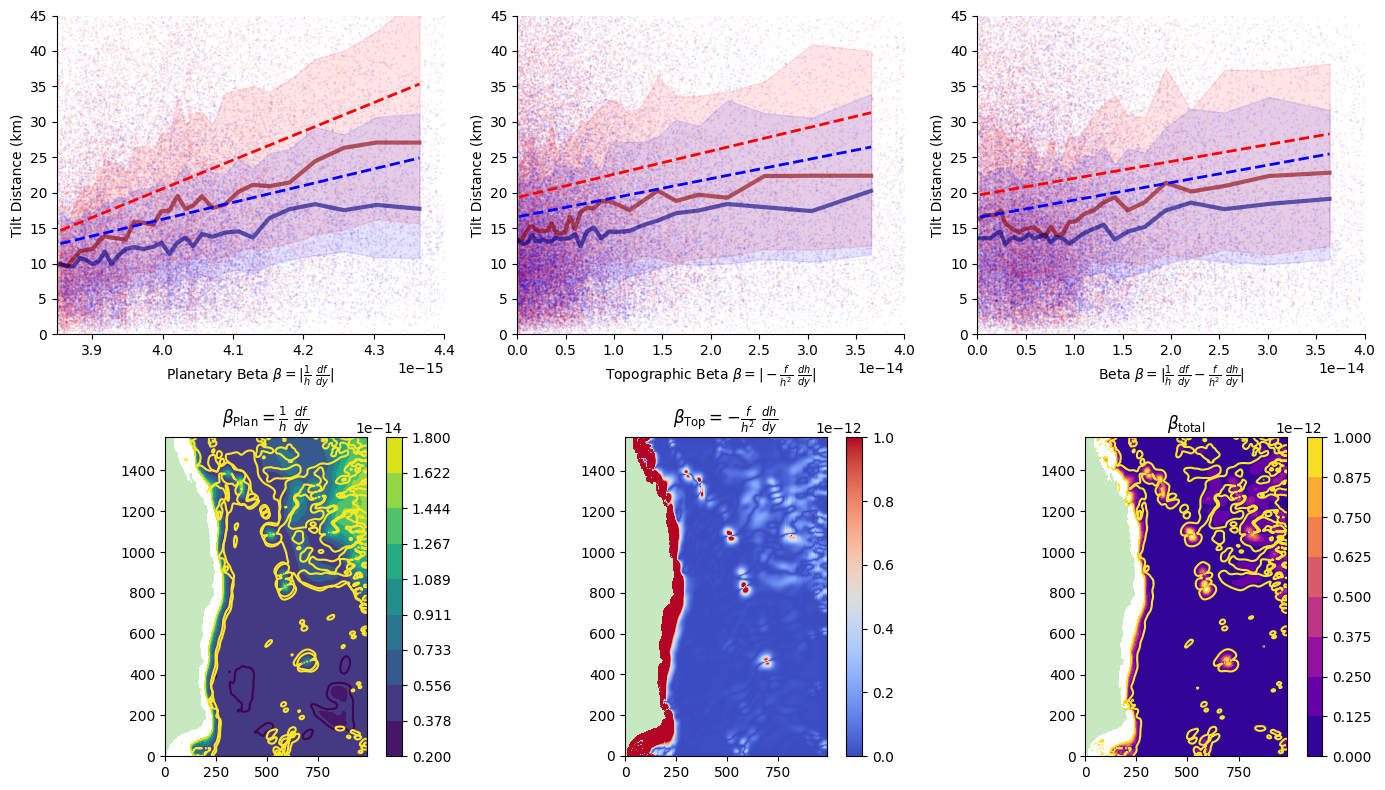

In [62]:
beta_panel_2x3(xcap1_min=3.85e-15, xcap1_max=4.4e-15,
             xcap2_min=0, xcap2_max=.4e-13,
             xcap3_min=0, xcap3_max=.4e-13,
             scatter=True, ylim=45, sharey=False, linfit=True)


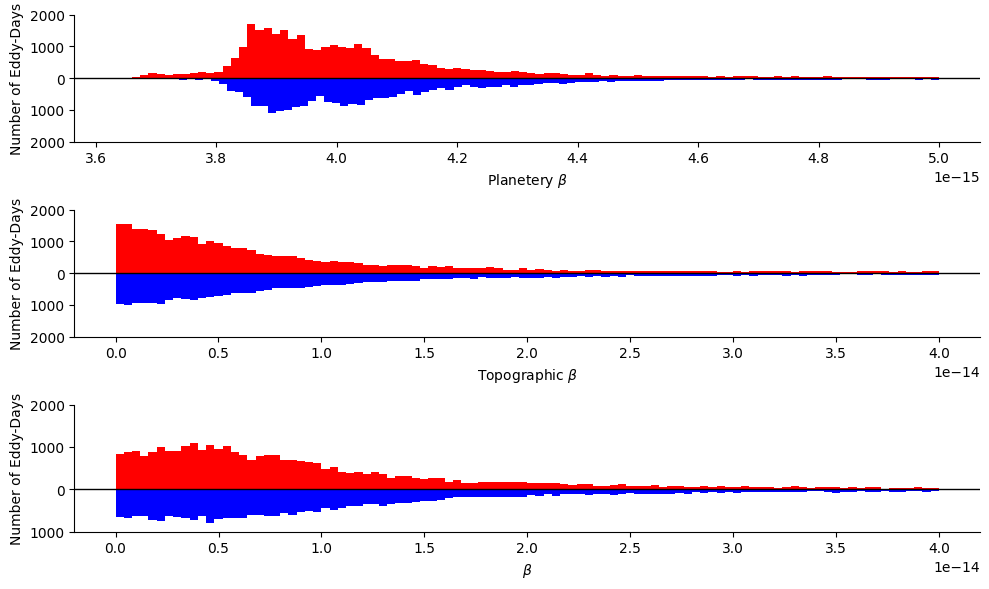

In [42]:
fig, axs = plt.subplots(3, 1, figsize=(10, 6), sharex=False)

# --- Plot 0 ---
ax = axs[0]
x2 = 5e-15
ages_ae = df_AE_[df_AE_.plan_beta_abs<=x2].plan_beta_abs
ages_ce = df_CE_[df_CE_.plan_beta_abs<=x2].plan_beta_abs
ax.hist(ages_ae, bins=100, color='r')
counts, bins = np.histogram(ages_ce, bins=100)
ax.bar(bins[:-1], -counts, width=np.diff(bins), color='b', align='edge')
ax.axhline(0, color='k', linewidth=1)
ax.set_xlabel(r'Planetery $\beta$')
ax.set_ylabel('Number of Eddy-Days')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_yticks(ax.get_yticks())
ax.set_yticklabels([abs(int(t)) for t in ax.get_yticks()])
# ax.set_ylim(-3000, 3000)

# --- Plot 1 ---
ax = axs[1]
x2 = .4e-13 
# x2 = 1.5e-14
ages_ae = df_AE_[df_AE_.top_beta_abs<=x2].top_beta_abs
ages_ce = df_CE_[df_CE_.top_beta_abs<=x2].top_beta_abs
ax.hist(ages_ae, bins=100, color='r')
counts, bins = np.histogram(ages_ce, bins=100)
ax.bar(bins[:-1], -counts, width=np.diff(bins), color='b', align='edge')
ax.axhline(0, color='k', linewidth=1)
ax.set_xlabel(r'Topographic $\beta$')
ax.set_ylabel('Number of Eddy-Days')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_yticks(ax.get_yticks())
ax.set_yticklabels([abs(int(t)) for t in ax.get_yticks()])
# ax.set_xlim(0, x2)

# --- Plot 2 ---
ax = axs[2]
x2 = .4e-13
ages_ae = df_AE_[df_AE_.beta<=x2].beta
ages_ce = df_CE_[df_CE_.beta<=x2].beta
ax.hist(ages_ae, bins=100, color='r')
counts, bins = np.histogram(ages_ce, bins=100)
ax.bar(bins[:-1], -counts, width=np.diff(bins), color='b', align='edge')
ax.axhline(0, color='k', linewidth=1)
ax.set_xlabel(r'$\beta$')
ax.set_ylabel('Number of Eddy-Days')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_yticks(ax.get_yticks())
ax.set_yticklabels([abs(int(t)) for t in ax.get_yticks()])
# ax.set_ylim(-3000, 3000)

plt.tight_layout()
plt.show()


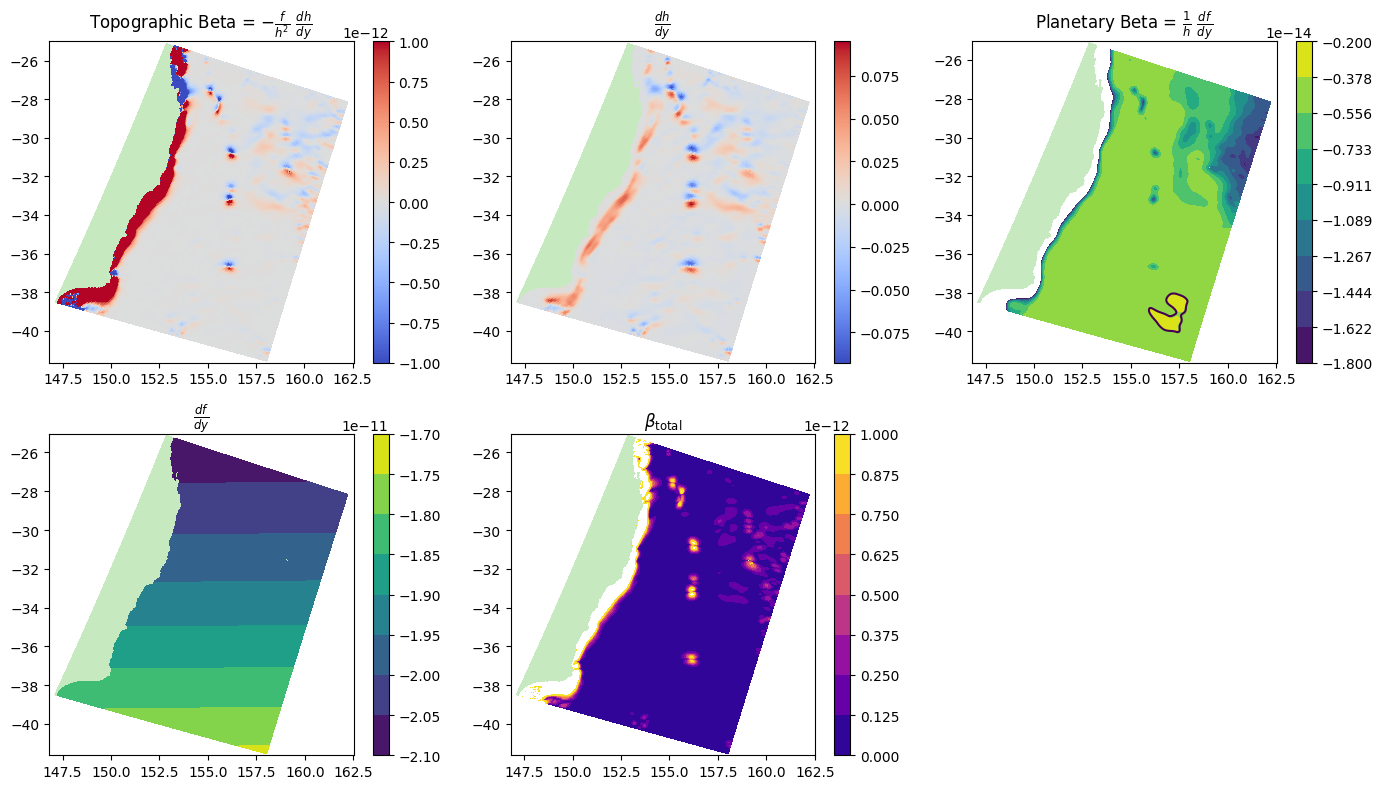

In [39]:
fig, axs = plt.subplots(2, 3, figsize=(14, 8))

# --------------------------------------------
# AX00
# --------------------------------------------
ax00 = axs[0, 0]
ax00.contourf(lon_rho, lat_rho, np.where(mask_rho, np.nan, 1), cmap='Greens')
im00 = ax00.pcolor(lon_rho, lat_rho, np.where(X_grid>0, beta_topo, np.nan),
                   cmap='coolwarm', vmin=-1e-12, vmax=1e-12)
plt.colorbar(im00, ax=ax00)
ax00.set_title(r'Topographic Beta = $-\frac{f}{h^2}\ \frac{dh}{dy}$')
ax00.axis('equal')

# --------------------------------------------
# AX01
# --------------------------------------------
ax01 = axs[0, 1]
ax01.contourf(lon_rho, lat_rho, np.where(mask_rho, np.nan, 1), cmap='Greens')
im01 = ax01.pcolor(lon_rho, lat_rho, np.where(X_grid>0, dh_dTN, np.nan),
                   cmap='coolwarm')
plt.colorbar(im01, ax=ax01)
ax01.set_title(r'$\frac{dh}{dy}$')
ax01.axis('equal')

# --------------------------------------------
# AX02
# --------------------------------------------
ax02 = axs[0, 2]
ax02.contourf(lon_rho, lat_rho, np.where(mask_rho, np.nan, 1), cmap='Greens')
im02 = ax02.contourf(
    lon_rho, lat_rho,
    np.where(X_grid>0, beta_plan, np.nan),
    levels=np.linspace(-1.8e-14, -0.2e-14, 10)
)
ax02.contour(
    lon_rho, lat_rho, beta_plan,
    levels=[-3.8e-15]
)
plt.colorbar(im02, ax=ax02)
ax02.set_title(r'Planetary Beta = $\frac{1}{h}\ \frac{df}{dy}$')
ax02.axis('equal')

# --------------------------------------------
# AX10
# --------------------------------------------
ax10 = axs[1, 0]
ax10.contourf(lon_rho, lat_rho, np.where(mask_rho, np.nan, 1), cmap='Greens')
im10 = ax10.contourf(
    lon_rho, lat_rho,
    np.where(mask_rho, df_dTN, np.nan)
)
plt.colorbar(im10, ax=ax10)
ax10.set_title(r'$\frac{df}{dy}$')
ax10.axis('equal')

# --------------------------------------------
# AX11
# --------------------------------------------
ax11 = axs[1, 1]
ax11.contourf(lon_rho, lat_rho, np.where(mask_rho, np.nan, 1), cmap='Greens')
im11 = ax11.contourf(
    lon_rho, lat_rho,
    np.where(mask_rho, np.abs(beta_plan + beta_topo), np.nan),
    levels=np.linspace(0, 1e-12, 9),
    cmap='plasma'
)
plt.colorbar(im11, ax=ax11)
ax11.set_title(r'$\beta_{\rm total}$')
ax11.axis('equal')

# --------------------------------------------
# AX12 — empty panel (or delete)
# --------------------------------------------
ax12 = axs[1, 2]
ax12.axis('off')
ax12.set_title('')

plt.tight_layout()
plt.show()


### Time Analysis

In [ ]:
break

AttributeError: 'DataFrame' object has no attribute 'norm_time'

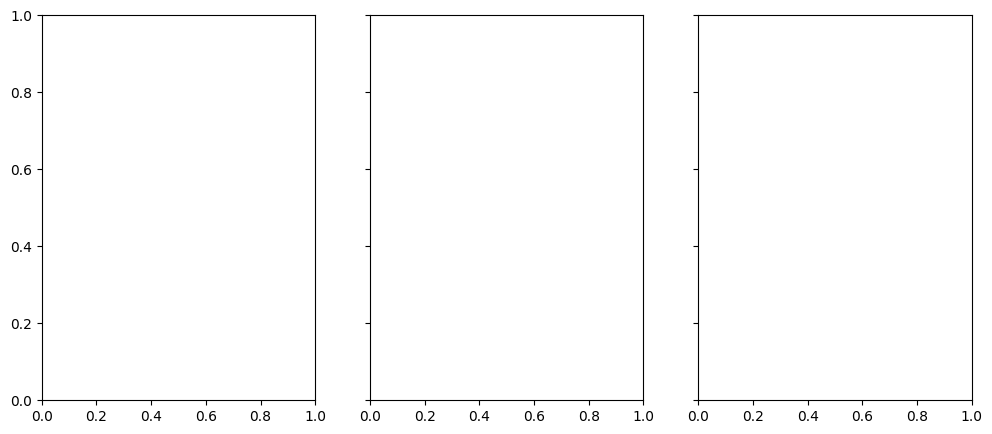

In [19]:
bin_width = 0.02

styles = {
    'AE': {'line': 'darkred', 'fill': 'red'},
    'CE': {'line': 'navy',    'fill': 'blue'}
}

age_bins = [(0, 49), (50, 99), (100, np.inf)]
labels = ['Age [0,49]', 'Age [50,99]', r'Age [100,$\inf$)']

fig, axes = plt.subplots(1, 3, figsize=(12, 5), sharey=True)

for ax, (age1, age2), title in zip(axes, age_bins, labels):

    df_sel = {}
    for cyc, df_data in zip(['AE', 'CE'], [df_AE, df_CE]):
        df_list = []
        for eddy in df_data.Eddy.unique():
            seg = df_data[df_data.Eddy == eddy]
            if (seg.Age.iloc[0] >= age1) & (seg.Age.iloc[0] <= age2):
                df_list.append(pd.DataFrame({'x': seg.norm_time, 'y': seg.TiltDis}))
        df_sel[cyc] = pd.concat(df_list, ignore_index=True).dropna() if df_list else \
                      pd.DataFrame(columns=['x','y'])

    x_arrays = [df_sel['AE'].x.values, df_sel['CE'].x.values]
    x_all = np.concatenate([arr for arr in x_arrays if len(arr)>0])
    bins = np.arange(x_all.min(), x_all.max() + bin_width, bin_width)

    for cyc in ['AE','CE']:
        df = df_sel[cyc]
        if df.empty:
            continue

        x = df.x.values
        y = df.y.values

        df['bin'] = pd.cut(df.x, bins=bins, include_lowest=True)
        grp = df.groupby('bin', observed=False)['y']
        med = grp.median()
        q25 = grp.quantile(0.25)
        q75 = grp.quantile(0.75)

        bin_centers = np.array([b.mid for b in med.index])
        m = med.notna()

        ax.plot(bin_centers[m], med[m], lw=3, color=styles[cyc]['line'], alpha=0.6, label=f'{cyc} median')
        ax.fill_between(bin_centers[m], q25[m], q75[m], color=styles[cyc]['fill'], alpha=0.15, label=f'{cyc} IQR')

        slope, intercept, r, p, err = linregress(x, y)
        xl = np.linspace(x.min(), x.max(), 200)
        yl = slope * xl + intercept
        # Uncomment if you'd like regression lines
        # ax.plot(xl, yl, '--', lw=3, color=styles[cyc]['fill'], alpha=0.6)

    ax.set_title(title)
    ax.set_ylim(0, 45)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xlabel('Normalised Time', fontsize=12)

axes[2].legend(loc='upper right', ncol=2)
axes[0].set_ylabel('Tilt Distance (km)', fontsize=12)
plt.tight_layout()
plt.show()







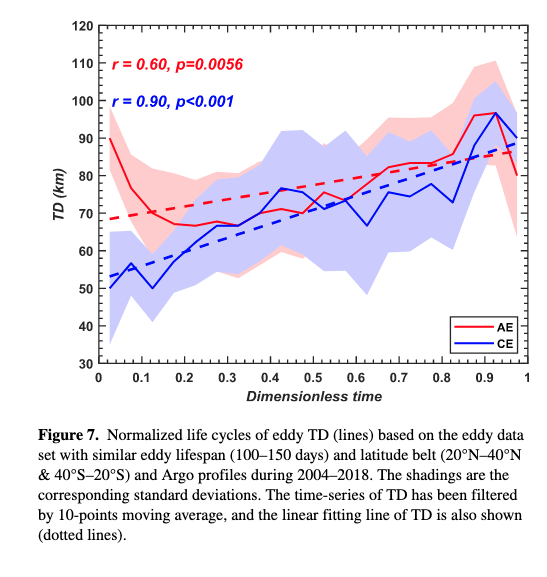

In [ ]:
import matplotlib.cm as cm

ae = df_eddies[df_eddies.Cyc == 'AE'].Eddy.unique()
ce = df_eddies[df_eddies.Cyc == 'CE'].Eddy.unique()
# colour ranges
colors_ae = cm.Reds(np.linspace(0.4, 1, len(ae)))
colors_ce = cm.Blues(np.linspace(0.4, 1, len(ce)))

fig, axs = plt.subplots(2, 1, figsize=(15,6), sharex=True)
ae_idx, ce_idx = 0, 0
for eddy in df_eddies.Eddy.unique():
    df = df_eddies[df_eddies.Eddy==eddy]
    if df.Cyc.iloc[0] == 'AE':
        axs[0].plot(np.arange(len(df)), df.TiltDis, color=colors_ae[ae_idx])
        # axs[0].set_xlabel('Day', fontsize=12)
        axs[0].set_ylabel('Tilt Distance (km)', fontsize=12)
        axs[0].spines['top'].set_visible(False)
        axs[0].spines['right'].set_visible(False)
        ae_idx += 1
    else:
        axs[1].plot(np.arange(len(df)), df.TiltDis, color=colors_ce[ce_idx])
        axs[1].set_xlabel('Day', fontsize=12)
        axs[1].set_ylabel('Tilt Distance (km)', fontsize=12)
        axs[1].spines['top'].set_visible(False)
        axs[1].spines['right'].set_visible(False)
        ce_idx += 1
axs[0].set_xlim(0, None); axs[1].set_xlim(0, None)
plt.tight_layout()


### Seasonality



In [ ]:
plt.figure(figsize=(15,5))

for label, df, c in [('AE', df_AE, 'r'), ('CE', df_CE, 'b')]:
    # mean = df.groupby(pd.Grouper(key='Date', freq='6MS')).TiltDis.mean()
    mean = df.groupby(pd.Grouper(key='Date', freq='1YE')).TiltDis.mean()
    plt.scatter(df.Date, df.TiltDis, s=1, alpha=0.1, color=c, marker='.')
    plt.plot(mean.index, mean.values, lw=2, color=c, label=label)

plt.xlabel('Date'); plt.legend()
plt.ylabel('Tilt Distance (km)')
plt.ylim(0, 40)
plt.show()


In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(10,4))

# -------------------
# 1) MONTHLY PANEL
# -------------------
ax = axs[0]

for label, df, c in [('AE', df_AE, 'r'), ('CE', df_CE, 'b')]:
    df_ = df.copy()
    df_['Month'] = df_.Date.dt.month

    g = df_.groupby('Month').TiltDis
    med = g.median()
    q25 = g.quantile(0.25)
    q75 = g.quantile(0.75)

    ax.plot(med.index, med.values, lw=2, color=c, label=label)
    ax.fill_between(med.index, q25, q75, color=c, alpha=0.15)

ax.set_xticks(range(1,13))
ax.set_xticklabels(['Jan','Feb','Mar','Apr','May','Jun',
                    'Jul','Aug','Sep','Oct','Nov','Dec'])
ax.set_xlabel('Month')
ax.set_ylabel('Tilt Distance (km)')
ax.set_ylim(0, 40)
ax.set_title('Monthly Median Tilt')
ax.grid(True)

# -------------------
# 2) SEASONAL PANEL
# -------------------
ax = axs[1]

season_map = {
    12:'Summer',1:'Summer',2:'Summer',
    3:'Autumn',4:'Autumn',5:'Autumn',
    6:'Winter',7:'Winter',8:'Winter',
    9:'Spring',10:'Spring',11:'Spring'
}
season_order = ['Summer','Autumn','Winter','Spring']

for label, df, c in [('AE', df_AE, 'r'), ('CE', df_CE, 'b')]:
    df_ = df.copy()
    df_['Season'] = df_['Date'].dt.month.map(season_map)
    df_['Season'] = pd.Categorical(df_['Season'], categories=season_order, ordered=True)

    g = df_.groupby('Season', observed=True).TiltDis
    med = g.median().reindex(season_order)
    q25 = g.quantile(0.25).reindex(season_order)
    q75 = g.quantile(0.75).reindex(season_order)

    x = np.arange(len(season_order))
    ax.plot(x, med.values, lw=2, marker='o', color=c, label=label)
    ax.fill_between(x, q25, q75, color=c, alpha=0.15)

ax.set_xticks(x)
ax.set_xticklabels(season_order)
ax.set_xlabel('Season')
ax.set_ylabel('Tilt Distance (km)')
ax.set_ylim(0, 40)
ax.set_title('Seasonal Median Tilt')
ax.legend()
ax.grid(True)

plt.tight_layout()
plt.show()


Could hypothesis that warmer waters = more stratified water = more tilt

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(10,4))

# -------------------
# 1) MONTHLY PANEL
# -------------------
ax = axs[0]

for label, df, c in [('AE', df_AE, 'r'), ('CE', df_CE, 'b')]:
    df_ = df.copy()
    df_['Month'] = df_.Date.dt.month

    g = df_.groupby('Month').Nbar
    med = g.median()
    q25 = g.quantile(0.25)
    q75 = g.quantile(0.75)

    ax.plot(med.index, med.values, lw=2, color=c, label=label)
    ax.fill_between(med.index, q25, q75, color=c, alpha=0.15)

ax.set_xticks(range(1,13))
ax.set_xticklabels(['Jan','Feb','Mar','Apr','May','Jun',
                    'Jul','Aug','Sep','Oct','Nov','Dec'])
ax.set_xlabel('Month')
ax.set_ylabel(r'$\bar{N}$')
# ax.set_ylim(0, 40)
# ax.set_title('Monthly Median Tilt')
ax.grid(True)

# -------------------
# 2) SEASONAL PANEL
# -------------------
ax = axs[1]

season_map = {
    12:'Summer',1:'Summer',2:'Summer',
    3:'Autumn',4:'Autumn',5:'Autumn',
    6:'Winter',7:'Winter',8:'Winter',
    9:'Spring',10:'Spring',11:'Spring'
}
season_order = ['Summer','Autumn','Winter','Spring']

for label, df, c in [('AE', df_AE, 'r'), ('CE', df_CE, 'b')]:
    df_ = df.copy()
    df_['Season'] = df_['Date'].dt.month.map(season_map)
    df_['Season'] = pd.Categorical(df_['Season'], categories=season_order, ordered=True)

    g = df_.groupby('Season', observed=True).Nbar
    med = g.median().reindex(season_order)
    q25 = g.quantile(0.25).reindex(season_order)
    q75 = g.quantile(0.75).reindex(season_order)

    x = np.arange(len(season_order))
    ax.plot(x, med.values, lw=2, marker='o', color=c, label=label)
    ax.fill_between(x, q25, q75, color=c, alpha=0.15)

ax.set_xticks(x)
ax.set_xticklabels(season_order)
ax.set_xlabel('Season')
ax.set_ylabel(r'$\bar{N}$')
# ax.set_ylim(0, 40)
# ax.set_title('Seasonal Median Tilt')
ax.legend()
ax.grid(True)

plt.tight_layout()
plt.show


In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(10,4))

# -------------------
# 1) MONTHLY PANEL
# -------------------
ax = axs[0]

for label, df, c in [('AE', df_AE, 'r'), ('CE', df_CE, 'b')]:
    df_ = df.copy()
    df_['Month'] = df_.Date.dt.month

    g = df_.groupby('Month').w
    med = np.abs(g.median())
    q25 = np.abs(g.quantile(0.25))
    q75 = np.abs(g.quantile(0.75))

    ax.plot(med.index, med.values, lw=2, color=c, label=label)
    ax.fill_between(med.index, q25, q75, color=c, alpha=0.15)

ax.set_xticks(range(1,13))
ax.set_xticklabels(['Jan','Feb','Mar','Apr','May','Jun',
                    'Jul','Aug','Sep','Oct','Nov','Dec'])
ax.set_xlabel('Month')
ax.set_ylabel(r'$\omega$')
# ax.set_ylim(0, 40)
# ax.set_title('Monthly Median Tilt')
ax.grid(True)

# -------------------
# 2) SEASONAL PANEL
# -------------------
ax = axs[1]

season_map = {
    12:'Summer',1:'Summer',2:'Summer',
    3:'Autumn',4:'Autumn',5:'Autumn',
    6:'Winter',7:'Winter',8:'Winter',
    9:'Spring',10:'Spring',11:'Spring'
}
season_order = ['Summer','Autumn','Winter','Spring']

for label, df, c in [('AE', df_AE, 'r'), ('CE', df_CE, 'b')]:
    df_ = df.copy()
    df_['Season'] = df_['Date'].dt.month.map(season_map)
    df_['Season'] = pd.Categorical(df_['Season'], categories=season_order, ordered=True)

    g = df_.groupby('Season', observed=True).w
    med = np.abs(g.median().reindex(season_order))
    q25 = np.abs(g.quantile(0.25).reindex(season_order))
    q75 = np.abs(g.quantile(0.75).reindex(season_order))

    x = np.arange(len(season_order))
    ax.plot(x, med.values, lw=2, marker='o', color=c, label=label)
    ax.fill_between(x, q25, q75, color=c, alpha=0.15)

ax.set_xticks(x)
ax.set_xticklabels(season_order)
ax.set_xlabel('Season')
ax.set_ylabel(r'$\omega$')
# ax.set_ylim(0, 40)
# ax.set_title('Seasonal Median Tilt')
ax.legend()
ax.grid(True)

plt.tight_layout()
plt.show()



### Temperature

### Eddy Propogation

In [ ]:
# fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 4), constrained_layout=True)

# styles = {
#     'AE': {'line': 'darkred',  'fill': 'red'},
#     'CE': {'line': 'navy',     'fill': 'blue'}
# }

# # ======================================================================
# # PANEL 1: Tilt vs EddyProp
# # ======================================================================

# split1 = 0.15
# int1, int2 = 0.01, 0.05
# bins1 = np.concatenate([
#     np.arange(0, split1, int1),
#     np.arange(split1, 0.4 + int2, int2)
# ])
# bin_centers1 = 0.5 * (bins1[:-1] + bins1[1:])

# for cyc, df_cyc in [('AE', df_AE), ('CE', df_CE)]:
#     df = df_cyc[['EddyProp', 'TiltDis']].dropna().copy()
#     xval = df['EddyProp'].values
#     tilt = df['TiltDis'].values

#     digitized = np.digitize(xval, bins1)
#     median = [np.nanmedian(tilt[digitized == i])        for i in range(1, len(bins1))]
#     q25    = [np.nanquantile(tilt[digitized == i], .25) for i in range(1, len(bins1))]
#     q75    = [np.nanquantile(tilt[digitized == i], .75) for i in range(1, len(bins1))]

#     median = np.array(median)
#     q25    = np.array(q25)
#     q75    = np.array(q75)
#     mask   = np.isfinite(median)

#     # ax1.scatter(xval, tilt, s=1, alpha=0.08, marker='.',
#     #        color=styles[cyc]['fill'])

#     ax1.plot(bin_centers1[mask], median[mask],
#              lw=3, alpha=.6, color=styles[cyc]['line'],
#              label=f'{cyc} median')

#     ax1.fill_between(bin_centers1[mask], q25[mask], q75[mask],
#                      alpha=0.10, color=styles[cyc]['fill'],
#                      label=f'{cyc} IQR')

#     if len(xval) > 2:
#         m, c, r, p, se = linregress(xval, tilt)
#         xx = np.linspace(xval.min(), xval.max(), 100)
#         yy = m * xx + c
#         eq_str = f'TD = {m:.2f} U + {c:.2f}' if c >= 0 else f'TD = {m:.2f} U - {abs(c):.2f}'
#         p_str  = 'p<0.001' if p < 0.001 else f'p = {p:.3f}'
#         ax1.plot(xx, yy, '--', lw=2, color=styles[cyc]['fill'],
#                  label=f'{cyc}: {eq_str} ({p_str})')

# ax1.set_xlim(0, 0.4)
# ax1.set_ylim(0, 60)
# ax1.set_xlabel(r'Surface Propagation Speed (ms$^{-1}$)')
# ax1.set_ylabel('Tilt Distance (km)')
# ax1.spines['top'].set_visible(False)
# ax1.spines['right'].set_visible(False)
# ax1.legend(loc='upper left', ncol=1)

# # ======================================================================
# # PANEL 2: Tilt vs btm_prop (same as EddyProp)
# # ======================================================================

# for cyc, df_cyc in [('AE', df_AE), ('CE', df_CE)]:
#     df = df_cyc[['btm_prop', 'TiltDis']].dropna().copy()
#     xval = df['btm_prop'].values
#     tilt = df['TiltDis'].values

#     digitized = np.digitize(xval, bins1)
#     median = [np.nanmedian(tilt[digitized == i])        for i in range(1, len(bins1))]
#     q25    = [np.nanquantile(tilt[digitized == i], .25) for i in range(1, len(bins1))]
#     q75    = [np.nanquantile(tilt[digitized == i], .75) for i in range(1, len(bins1))]

#     median = np.array(median)
#     q25    = np.array(q25)
#     q75    = np.array(q75)
#     mask   = np.isfinite(median)

#     # ax2.scatter(xval, tilt, s=1, alpha=0.08, marker='.',
#     #        color=styles[cyc]['fill'])

#     ax2.plot(bin_centers1[mask], median[mask],
#              lw=3, alpha=.6, color=styles[cyc]['line'],
#              label='')

#     ax2.fill_between(bin_centers1[mask], q25[mask], q75[mask],
#                      alpha=0.10, color=styles[cyc]['fill'],
#                      label='')

#     if len(xval) > 2:
#         m, c, r, p, se = linregress(xval, tilt)
#         xx = np.linspace(xval.min(), xval.max(), 100)
#         yy = m * xx + c
#         eq_str = f'TD = {m:.2f} U + {c:.2f}' if c >= 0 else f'TD = {m:.2f} U - {abs(c):.2f}'
#         p_str  = 'p<0.001' if p < 0.001 else f'p = {p:.3f}'
#         ax2.plot(xx, yy, '--', lw=2, color=styles[cyc]['fill'],
#                  label=f'{cyc}: {eq_str} ({p_str})')

# ax2.set_xlim(0, 0.4)
# ax2.set_ylim(0, 60)
# ax2.set_xlabel(r'Bottom Propagation Speed (ms$^{-1}$)')
# ax2.set_ylabel('Tilt Distance (km)')
# ax2.spines['top'].set_visible(False)
# ax2.spines['right'].set_visible(False)
# ax2.legend(loc='upper left', ncol=1)

# # ======================================================================
# # PANEL 3: Tilt vs top_btm_diff
# # ======================================================================

# split2 = 0.2
# int1, int2 = 0.02, 0.4
# bins2 = np.concatenate([
#     np.arange(0, split2, int1),
#     np.arange(split2, 1.8 + int2, int2)
# ])
# bin_centers2 = 0.5 * (bins2[:-1] + bins2[1:])

# for cyc, df_cyc in [('AE', df_AE), ('CE', df_CE)]:
#     df = df_cyc[['top_btm_diff', 'TiltDis']].dropna().copy()
#     xval = df['top_btm_diff'].values
#     tilt = df['TiltDis'].values

#     digitized = np.digitize(xval, bins2)
#     median = [np.nanmedian(tilt[digitized == i])        for i in range(1, len(bins2))]
#     q25    = [np.nanquantile(tilt[digitized == i], .25) for i in range(1, len(bins2))]
#     q75    = [np.nanquantile(tilt[digitized == i], .75) for i in range(1, len(bins2))]

#     median = np.array(median)
#     q25    = np.array(q25)
#     q75    = np.array(q75)
#     mask   = np.isfinite(median)

#     # ax3.scatter(xval, tilt, s=1, alpha=0.08, marker='.',
#     #        color=styles[cyc]['fill'])

#     ax3.plot(bin_centers2[mask], median[mask],
#              lw=3, alpha=.6, color=styles[cyc]['line'],
#              label='')

#     ax3.fill_between(bin_centers2[mask], q25[mask], q75[mask],
#                      alpha=0.10, color=styles[cyc]['fill'],
#                      label='')

#     if len(xval) > 2:
#         m, c, r, p, se = linregress(xval, tilt)
#         xx = np.linspace(xval.min(), xval.max(), 100)
#         yy = m * xx + c
#         eq_str = f'TD = {m:.2f} ΔU + {c:.2f}' if c >= 0 else f'TD = {m:.2f} ΔU - {abs(c):.2f}'
#         p_str  = 'p<0.001' if p < 0.001 else f'p = {p:.3f}'
#         ax3.plot(xx, yy, '--', lw=2, color=styles[cyc]['fill'],
#                  label=f'{cyc}: {eq_str} ({p_str})')

# ax3.set_xlim(0, 1.6)
# ax3.set_ylim(0, 60)
# ax3.set_xlabel(r'Propagation ||Top - Bottom|| (ms$^{-1}$)')
# ax3.set_ylabel('Tilt Distance (km)')
# ax3.spines['top'].set_visible(False)
# ax3.spines['right'].set_visible(False)
# ax3.legend(loc='upper left', ncol=1)

# plt.show()





### Vorticity

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))

styles = {
    'AE': {'line': 'darkred',  'fill': 'red'},
    'CE': {'line': 'navy',     'fill': 'blue'}
}

# ------------------------------------------------------------
# Build quantile-based bins using ALL w > 0
# ------------------------------------------------------------
df_all = df_eddies.copy()
df_all = df_all.dropna(subset=['w'])
w_all = df_all.w.abs().values

nbins = 30
bins = np.quantile(w_all, np.linspace(0, 1, nbins + 1))
bins = np.unique(bins)
bin_centers = 0.5 * (bins[:-1] + bins[1:])

# ------------------------------------------------------------
# MAIN PLOT
# ------------------------------------------------------------
for cyc in ['AE', 'CE']:

    df_masked = df_eddies[df_eddies.Cyc == cyc].copy()
    df_masked = df_masked.dropna(subset=['w', 'TiltDis'])

    xval = df_masked['w'].abs().values
    tilt = df_masked['TiltDis'].values

    # bin everything — no masking whatsoever
    digitized = np.digitize(xval, bins)

    median = [np.nanmedian(tilt[digitized == i]) for i in range(1, len(bins))]
    q25    = [np.nanquantile(tilt[digitized == i], .25) for i in range(1, len(bins))]
    q75    = [np.nanquantile(tilt[digitized == i], .75) for i in range(1, len(bins))]

    ax.plot(bin_centers, median, lw=3, color=styles[cyc]['line'],
            alpha=.6, label=f'{cyc} median')

    ax.fill_between(bin_centers, q25, q75,
                    color=styles[cyc]['fill'], alpha=0.10, label=f'{cyc} IQR')

    # ------------------------------------------------------------
    # Linear regression only limits the *fit*, not the data used
    # ------------------------------------------------------------
    mask_reg = (xval >= 1e-5) & (xval <= 5e-5)

    if mask_reg.sum() > 2:
        xr = xval[mask_reg]
        yr = tilt[mask_reg]

        m, c, r, p, se = linregress(xr, yr)

        x_fit = np.linspace(1e-5, 5e-5, 200)
        y_fit = m * x_fit + c

        ax.plot(x_fit, y_fit, '--', lw=3, color=styles[cyc]['fill'],
                label=f'{cyc}: TD={m:.2e} ω + {c:.2f}')

# ------------------------------------------------------------
# Formatting
# ------------------------------------------------------------
# ax.set_xlim(w_all.min(), w_all.max())
# ax.set_ylim(0, np.nanmax(df_eddies.TiltDis) * 1.1)

ax.set_xlim(1e-5, 4e-5)
ax.set_ylim(0, 40)
ax.set_xlabel(r'|Vorticity| (s$^{-1}$)')
ax.set_ylabel('Tilt Distance (km)')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.legend(loc='upper right', ncol=2)

plt.tight_layout()
plt.show()

In [ ]:
from scipy.stats import linregress

fig, ax = plt.subplots(figsize=(10, 5))

styles = {
    'AE': {'line': 'darkred',  'fill': 'red'},
    'CE': {'line': 'navy',     'fill': 'blue'}
}

# ------------------------------------------------------------
# Build quantile-based bins
# ------------------------------------------------------------
df_all = df_eddies.dropna(subset=['Ro'])
w_all = df_all.Ro.abs().values

nbins = 30
bins = np.quantile(w_all, np.linspace(0, 1, nbins + 1))
bins = np.unique(bins)
bin_centers = 0.5 * (bins[:-1] + bins[1:])

# ------------------------------------------------------------
# MAIN PLOT
# ------------------------------------------------------------
for cyc in ['AE', 'CE']:
    df_masked = df_eddies[df_eddies.Cyc == cyc].dropna(subset=['Ro','TiltDis'])

    xval = df_masked['Ro'].abs().values
    tilt = df_masked['TiltDis'].values

    digitized = np.digitize(xval, bins)

    median = [np.nanmedian(tilt[digitized == i])        for i in range(1, len(bins))]
    q25    = [np.nanquantile(tilt[digitized == i], .25) for i in range(1, len(bins))]
    q75    = [np.nanquantile(tilt[digitized == i], .75) for i in range(1, len(bins))]

    # ax.scatter(xval, tilt, s=1, alpha=0.08, marker='.',
    #            color=styles[cyc]['fill'])

    # median + IQR
    ax.plot(bin_centers, median, alpha=.6,
            lw=3, color=styles[cyc]['line'],
            label=f'{cyc} median')

    ax.fill_between(bin_centers, q25, q75,
                    color=styles[cyc]['fill'], alpha=0.10,
                    label=f'{cyc} IQR')

    # ------------------------------------------------------------
    # Linear regression restricted to 0.1 <= Ro <= 0.5
    # ------------------------------------------------------------
    mask_reg = (xval >= 0.1) & (xval <= 0.5)

    if mask_reg.sum() > 2:
        xr = xval[mask_reg]
        yr = tilt[mask_reg]

        m, c, r, p, se = linregress(xr, yr)

        x_line = np.linspace(0.1, 0.5, 200)
        y_line = m * x_line + c
        p_str  = 'p<0.001' if p < 0.001 else f'p = {p:.3f}'

        ax.plot(x_line, y_line, '--', lw=3,
                color=styles[cyc]['fill'],
                label=f'{cyc}:  TD={m:.2f}Ro + {c:.2f} ({p_str})')

# ------------------------------------------------------------
# Formattin
# ------------------------------------------------------------
ax.set_xlim(0.1, .5)
ax.set_ylim(0, 50)
ax.set_xlabel(r'Rossby Number $|\omega/f|$')
ax.set_ylabel('Tilt Distance (km)')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.legend(loc='upper right', ncol=2)
plt.tight_layout()
plt.show()


In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))

styles = {
    'AE': {'line': 'darkred',  'fill': 'red'},
    'CE': {'line': 'navy',     'fill': 'blue'}
}

# ------------------------------------------------------------
# Build quantile-based bins using ALL w > 0
# ------------------------------------------------------------
df_all = df_eddies.copy()
df_all = df_all.dropna(subset=['PV'])
w_all = df_all.PV.abs().values

nbins = 30
bins = np.quantile(w_all, np.linspace(0, 1, nbins + 1))
bins = np.unique(bins)
bin_centers = 0.5 * (bins[:-1] + bins[1:])

# ------------------------------------------------------------
# MAIN PLOT
# ------------------------------------------------------------
for cyc in ['AE', 'CE']:

    df_masked = df_eddies[df_eddies.Cyc == cyc].copy()
    df_masked = df_masked.dropna(subset=['PV', 'TiltDis'])

    xval = df_masked['PV'].abs().values
    tilt = df_masked['TiltDis'].values

    # bin everything — no masking whatsoever
    digitized = np.digitize(xval, bins)

    median = [np.nanmedian(tilt[digitized == i]) for i in range(1, len(bins))]
    q25    = [np.nanquantile(tilt[digitized == i], .25) for i in range(1, len(bins))]
    q75    = [np.nanquantile(tilt[digitized == i], .75) for i in range(1, len(bins))]

    # scatter
    ax.scatter(xval, tilt, s=1, alpha=0.08, marker='.',
               color=styles[cyc]['fill'])

    ax.plot(bin_centers, median, lw=3, color=styles[cyc]['line'],
            alpha=.6, label=f'{cyc} median')

    ax.fill_between(bin_centers, q25, q75,
                    color=styles[cyc]['fill'], alpha=0.10, label=f'{cyc} IQR')

    # # ------------------------------------------------------------
    # # Linear regression only limits the *fit*, not the data used
    # # ------------------------------------------------------------
    # mask_reg = (xval >= 1e-5) & (xval <= 5e-5)

    # if mask_reg.sum() > 2:
    #     xr = xval[mask_reg]
    #     yr = tilt[mask_reg]

    #     m, c, r, p, se = linregress(xr, yr)

    #     x_fit = np.linspace(1e-5, 5e-5, 200)
    #     y_fit = m * x_fit + c

    #     ax.plot(x_fit, y_fit, '--', lw=3, color=styles[cyc]['fill'],
    #             label=f'{cyc}: TD={m:.2e} ω + {c:.2f}')

# ------------------------------------------------------------
# Formatting
# ------------------------------------------------------------
# ax.set_xlim(w_all.min(), w_all.max())
# ax.set_ylim(0, np.nanmax(df_eddies.TiltDis) * 1.1)

ax.set_xlim(0, .81e-7)
# ax.set_ylim(0, 40)
ax.set_xlabel(r'Potential Vorticity')
ax.set_ylabel('Tilt Distance (km)')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.legend(loc='upper right', ncol=2)

plt.tight_layout()
plt.show()

### Eddy Size and Deformation

In [ ]:
from scipy.stats import linregress

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(11, 4), constrained_layout=True, sharey=False)

styles = {
    'AE': {'line': 'darkred',  'fill': 'red'},
    'CE': {'line': 'navy',     'fill': 'blue'}
}

# ======================================================================
# PANEL 1: Tilt vs AR
# ======================================================================

df_all = df_eddies.copy()
df_all = df_all[df_all.AR < 3.5].dropna(subset=['AR'])
w_all = df_all.AR.values

# quantile-based bins
nbins = 20
bins = np.quantile(w_all, np.linspace(0, 1, nbins + 1))
bins = np.unique(bins)

for cyc, df_cyc in [('AE', df_AE), ('CE', df_CE)]:

    dfp = df_cyc.copy()
    dfp = dfp[dfp.AR < 3.5].dropna(subset=['AR', 'TiltDis'])

    # --------- median / IQR ----------
    dfp['bin'] = pd.cut(dfp.AR, bins=bins, include_lowest=True)
    grouped = dfp.groupby('bin', observed=False).TiltDis

    median = grouped.median()
    q25    = grouped.quantile(0.25)
    q75    = grouped.quantile(0.75)

    bin_centers = np.array([0.5 * (b.left + b.right) for b in median.index])
    mask = median.notna()

    # ax.scatter(dfp.AR.values, dfp.TiltDis.values,
    #            s=1, alpha=0.1, marker='.', color=styles[cyc]['fill'])

    ax1.plot(bin_centers[mask], median.values[mask], lw=3, alpha=.6,
            color=styles[cyc]['line'], label='')#f'{cyc} median')

    ax1.fill_between(bin_centers[mask], q25.values[mask], q75.values[mask],
                    color=styles[cyc]['fill'], alpha=0.12, label='')#f'{cyc} IQR')

    # --------- linear regression ----------
    ar = dfp.AR.values
    td = dfp.TiltDis.values

    mask_reg = (ar >= 1.0) & (ar <= 2.25)

    xr = np.asarray(ar[mask_reg], float).ravel()
    yr = np.asarray(td[mask_reg], float).ravel()

    # drop any NaNs just in case
    valid = np.isfinite(xr) & np.isfinite(yr)
    xr, yr = xr[valid], yr[valid]

    if xr.size > 1:
        m, c, r, p, se = linregress(xr, yr)
        x_fit = np.linspace(1.0, 2.25, 200)
        y_fit = m * x_fit + c
        p_str  = 'p<0.001' if p < 0.001 else f'p = {p:.3f}'
        
        ax1.plot(x_fit, y_fit, '--', lw=3, color=styles[cyc]['fill'],
                label=fr'{cyc}: TD={m:.2f} $\alpha$ + {c:.2f} ({p_str})')

ax1.set_xlim(1, 2.25)
ax1.set_ylim(0, 50)
ax1.set_xlabel(r'Surface Aspect Ratio ($\alpha$)')
ax1.set_ylabel('Tilt Distance (km)')
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.legend(loc='upper left', ncol=1)

# ======================================================================
# PANEL 2: Tilt vs Rc
# ======================================================================

df_all = df_eddies.copy()
df_all = df_all.dropna(subset=['Rc'])

w_all = df_all.Rc.values

# quantile-based bins
nbins = 20
bins = np.quantile(w_all, np.linspace(0, 1, nbins + 1))
bins = np.unique(bins)

for cyc, df_cyc in [('AE', df_AE), ('CE', df_CE)]:

    dfp = df_cyc.copy()
    dfp = dfp.dropna(subset=['Rc', 'TiltDis'])

    # --------- median / IQR ----------
    dfp['bin'] = pd.cut(dfp.Rc, bins=bins, include_lowest=True)
    grouped = dfp.groupby('bin', observed=False).TiltDis

    median = grouped.median()
    q25    = grouped.quantile(0.25)
    q75    = grouped.quantile(0.75)

    bin_centers = np.array([0.5 * (b.left + b.right) for b in median.index])
    mask = median.notna()

    # ax.scatter(dfp.Rc.values, dfp.TiltDis.values,
    #            s=1, alpha=0.1, marker='.', color=styles[cyc]['fill'])

    ax2.plot(bin_centers[mask], median.values[mask], lw=3, alpha=.6,
            color=styles[cyc]['line'], label=f'{cyc} median')

    ax2.fill_between(bin_centers[mask], q25.values[mask], q75.values[mask],
                    color=styles[cyc]['fill'], alpha=0.12, label=f'{cyc} IQR')

# ax.set_xlim(1, 2.25)
# ax.set_ylim(0, 40)
ax2.set_xlabel(r'$R_c$')
ax2.set_ylabel('Tilt Distance (km)')
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.legend(loc='upper right', ncol=2)




### Bathymetry

In [ ]:
fig, (ax, ax_hist, ax2) = plt.subplots(
    1, 3, figsize=(14, 7),
    gridspec_kw={'width_ratios': [2, .5, 1]},
    constrained_layout=True
)

styles = {
    'AE': {'line': 'darkred',  'fill': 'red'},
    'CE': {'line': 'navy', 'fill': 'blue'}
}

split = 4.2
int1, int2 = 0.25, 0.1
bins = np.concatenate([
    np.arange(1.5, split, int1),
    np.arange(split, 5 + int2, int2)
])
bin_centers = 0.5 * (bins[:-1] + bins[1:])

bathy_AE = []
bathy_CE = []

for cyc in ['AE', 'CE']:
    df_masked = df_eddies[df_eddies.Cyc == cyc].dropna(subset=['h', 'TiltDis']).copy()

    bathy = df_masked['h'].values / 1e3
    tilt  = df_masked['TiltDis'].values

    if cyc == 'AE':
        bathy_AE.append(bathy)
    else:
        bathy_CE.append(bathy)

    digitized = np.digitize(bathy, bins)

    median = [np.nanmedian(tilt[digitized == i])        for i in range(1, len(bins))]
    q25    = [np.nanquantile(tilt[digitized == i], .25) for i in range(1, len(bins))]
    q75    = [np.nanquantile(tilt[digitized == i], .75) for i in range(1, len(bins))]

    # ax.scatter(bathy, tilt,
    #            s=1, alpha=0.1, marker='.', color=styles[cyc]['fill'])

    ax.plot(bin_centers, median, color=styles[cyc]['line'], lw=3, alpha=.6, label=f'{cyc} median')
    ax.fill_between(bin_centers, q25, q75, color=styles[cyc]['fill'], alpha=0.1, label=f'{cyc} IQR')

    mask_left = bathy < split
    if mask_left.sum() > 2:
        m1, c1, r1, p1, se1 = linregress(bathy[mask_left], tilt[mask_left])
        x1 = np.linspace(bathy[mask_left].min(), bathy[mask_left].max(), 100)
        y1 = m1 * x1 + c1
        eq_str = f'TD = {m1:.2f} h + {c1:.2f}' if c1 >= 0 else f'TD = {m1:.2f} h - {abs(c1):.2f}'
        p_str  = 'p<0.001' if p1 < 0.001 else f'p = {p1:.3f}'
        ax.plot(x1, y1, ':', lw=3, color=styles[cyc]['fill'], label=f'{cyc}: {eq_str} ({p_str})')

    mask_right = bathy >= split
    if mask_right.sum() > 2:
        m2, c2, r2, p2, se2 = linregress(bathy[mask_right], tilt[mask_right])
        x2 = np.linspace(bathy[mask_right].min(), bathy[mask_right].max(), 100)
        y2 = m2 * x2 + c2
        eq_str = f'TD = {m2:.2f} h + {c2:.2f}' if c2 >= 0 else f'TD = {m2:.2f} h - {abs(c2):.2f}'
        p_str  = 'p<0.001' if p2 < 0.001 else f'p = {p2:.3f}'
        ax.plot(x2, y2, '--', lw=3, color=styles[cyc]['fill'], label=f'{cyc}: {eq_str} ({p_str})')

bathy_AE = np.concatenate(bathy_AE) if bathy_AE else np.array([])
bathy_CE = np.concatenate(bathy_CE) if bathy_CE else np.array([])

ax.text(2.5, 40, f'Type 1\n(< {split} km)')
ax.text(4.5, 30, f'Type 2\n(≥ {split} km)')

# ------------------------------------------------------------------
# MIDDLE PANEL: TYPE 1 / TYPE 2 COUNTS (AE vs CE)
# Type 1: bathy < split
# Type 2: bathy >= split
# ------------------------------------------------------------------
type1_AE = np.sum(bathy_AE < split)
type2_AE = np.sum(bathy_AE >= split)
type1_CE = np.sum(bathy_CE < split)
type2_CE = np.sum(bathy_CE >= split)

x = np.arange(2)
width = 0.35

ax_hist.bar(x - width/2, [type1_AE, type2_AE],
            width=width, label='AE',
            alpha=0.7, color=styles['AE']['fill'])
ax_hist.bar(x + width/2, [type1_CE, type2_CE],
            width=width, label='CE',
            alpha=0.7, color=styles['CE']['fill'])

ax_hist.set_xticks(x)
ax_hist.set_xticklabels([f'Type 1\n(< {split} km)', f'Type 2\n(≥ {split} km)'])
ax_hist.set_ylabel('Count')
ax_hist.set_xlabel('Bathymetry class')
ax_hist.spines['top'].set_visible(False)
ax_hist.spines['right'].set_visible(False)
ax_hist.legend(loc='upper left')

# ------------------------------------------------------------------
# RIGHT PANEL: MAP (unchanged)
# ------------------------------------------------------------------
h_mask = np.where(mask_rho, h, np.nan)
cf = ax2.contourf(X_grid, Y_grid, np.where(h_mask/1e3 > split, np.nan, h_mask/1e3), cmap='Greens')#, vmax=split)
cbar = fig.colorbar(cf, ax=ax2, location='top')
cbar.set_label('Bathymetry (km)')
cf = ax2.contourf(X_grid, Y_grid, np.where(h_mask/1e3 < split, np.nan, h_mask/1e3), cmap='Blues')#, vmin=split)
cbar = fig.colorbar(cf, ax=ax2, location='top')
# cbar.set_label('Bathymetry (km)')
ax2.contourf(X_grid, Y_grid, np.where(mask_rho, np.nan, 1), cmap='Greys')
ax2.contour(X_grid, Y_grid, h/1e3, levels=[split], colors=['w'], linewidths=.5)

c1 = ax2.contour(X_grid, Y_grid, lat_rho, levels=levels_lat,
                colors='k', linewidths=0.5)
ax.clabel(c1, fmt=lambda v: f"{-v:.0f}°S", inline=True, colors='k')
c2 = ax2.contour(X_grid, Y_grid, lon_rho, levels=levels_lon,
                colors='k', linewidths=0.5)
ax.clabel(c2, fmt=lambda v: f"{v:.0f}°E", inline=True, colors='k')

ax2.text(550, 1400, f'Type 1\n(< {split} km)')
ax2.text(300, 300, f'Type 2\n(≥ {split} km)')

ax2.set_aspect('equal', adjustable='box')
ax2.set_xlabel('x (km)')
ax2.set_ylabel('y (km)')
ax2.spines['top'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax2.yaxis.tick_right()
ax2.yaxis.set_label_position("right")

# left panel cosmetics
# ax.set_xlim(bins.min(), bins.max())
ax.set_xlim(1.5, 5)
ax.set_ylim(0, 70)
ax.set_xlabel('Bathymetry (km)')
ax.set_ylabel('Tilt Distance (km)')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.legend(loc='upper left', ncol=2)

plt.show()


In [ ]:
fig, (ax, ax_hist, ax2) = plt.subplots(
    1, 3, figsize=(14, 7),
    gridspec_kw={'width_ratios': [2, .5, 1]},
    constrained_layout=True
)

styles = {
    'AE': {'line': 'darkred',  'fill': 'red'},
    'CE': {'line': 'navy', 'fill': 'blue'}
}

df = df_eddies.copy()
w = df.s

split_s = 0.01

int1, int2 = 0.001, 0.005
bins = np.concatenate([
    np.arange(w.min(), split_s, int1),
    np.arange(split_s, .1 + int2, int2)
])
bin_centers = 0.5 * (bins[:-1] + bins[1:])

slope_AE = []
slope_CE = []

for cyc in ['AE', 'CE']:
    df_masked = df_eddies[df_eddies.Cyc == cyc].copy()
    df_masked = df_masked.dropna(subset=['s', 'TiltDis'])

    slope_val = df_masked['s'].values
    tilt = df_masked['TiltDis'].values

    if cyc == 'AE':
        slope_AE.append(slope_val)
    else:
        slope_CE.append(slope_val)

    df_masked['bin'] = pd.cut(df_masked.s, bins=bins, include_lowest=True)
    grouped = df_masked.groupby('bin', observed=False).TiltDis

    median = grouped.median().values
    q25 = grouped.quantile(0.25).values
    q75 = grouped.quantile(0.75).values

    # ax.scatter(slope_val, tilt,
    #        s=1, alpha=0.1, marker='.', color=styles[cyc]['fill'])

    ax.plot(bin_centers, median, lw=3, alpha=.6,
            color=styles[cyc]['line'], label=f'{cyc} median')
    ax.fill_between(bin_centers, q25, q75,
                    color=styles[cyc]['fill'], alpha=0.12,
                    label=f'{cyc} IQR')

    mask_left = slope_val < split_s
    if mask_left.sum() > 2:
        m1, c1, r1, p1, se1 = linregress(slope_val[mask_left], tilt[mask_left])
        x1 = np.linspace(slope_val[mask_left].min(), slope_val[mask_left].max(), 200)
        y1 = m1 * x1 + c1
        eq_str = f'TD = {m1:.2f} S + {c1:.2f}' if c1 >= 0 else f'TD = {m1:.2f} S - {abs(c1):.2f}'
        p_str  = 'p<0.001' if p1 < 0.001 else f'p = {p1:.3f}'
        ax.plot(x1, y1, ':', lw=3, color=styles[cyc]['fill'],
                label=f'{cyc}: {eq_str} ({p_str})')

    mask_right = (slope_val >= split_s) & (slope_val <= .1)
    if mask_right.sum() > 2:
        m2, c2, r2, p2, se2 = linregress(slope_val[mask_right], tilt[mask_right])
        x2 = np.linspace(slope_val[mask_right].min(), slope_val[mask_right].max(), 200)
        y2 = m2 * x2 + c2
        eq_str = f'TD = {m2:.2f} S + {c2:.2f}' if c2 >= 0 else f'TD = {m2:.2f} S - {abs(c2):.2f}'
        p_str  = 'p<0.001' if p2 < 0.001 else f'p = {p2:.3f}'
        ax.plot(x2, y2, '--', lw=3, color=styles[cyc]['fill'],
                label=f'{cyc}: {eq_str} ({p_str})')

slope_AE = np.concatenate(slope_AE) if slope_AE else np.array([])
slope_CE = np.concatenate(slope_CE) if slope_CE else np.array([])

ax.text(0.005, 10, f'Type 1\n(< {split_s})')
ax.text(.04, 35, f'Type 2\n(≥ {split_s})')

ax.set_xlim(0, .1)
ax.set_ylim(0, 60)
ax.set_xlabel('Seabed Slope Magnitude (S)')
ax.set_ylabel('Tilt Distance (km)')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.legend(loc='upper left', ncol=2)

ax2.contourf(X_grid, Y_grid, np.where(mask_rho, np.nan, 1), cmap='Greys')
s_mask = np.where(mask_rho, s, np.nan)
cf = ax2.contourf(X_grid, Y_grid, np.where(s_mask > split_s, np.nan, s_mask), cmap='Oranges', levels=np.linspace(0, .01, 6))
cbar = fig.colorbar(cf, ax=ax2, location='top')
cbar.set_label('Seabed Slope Magnitude')
cf = ax2.contourf(X_grid, Y_grid, np.where(s_mask < split_s, np.nan, s_mask), cmap='Purples', levels=np.linspace(0.01, .16, 6))
cbar = fig.colorbar(cf, ax=ax2, location='top')
# cbar.set_label('Seabed Slope Magnitude')
ax2.contour(X_grid, Y_grid, s, levels=[split_s], colors=['w'], linewidths=1)

c1 = ax2.contour(X_grid, Y_grid, lat_rho, levels=levels_lat,
                colors='k', linewidths=0.5)
ax.clabel(c1, fmt=lambda v: f"{-v:.0f}°S", inline=True, colors='k')
c2 = ax2.contour(X_grid, Y_grid, lon_rho, levels=levels_lon,
                colors='k', linewidths=0.5)
ax.clabel(c2, fmt=lambda v: f"{v:.0f}°E", inline=True, colors='k')

ax2.text(300, 300, f'Type 1\n(< {split_s})')
ax2.text(20, 1100, f'Type 2\n(≥ {split_s})')
x0, y0 = 100, 1200
x1, y1 = 230, 1310
ax2.quiver(x0, y0, x1 - x0, y1 - y0, angles='xy', scale_units='xy', scale=1, zorder=5)

ax2.set_aspect('equal', adjustable='box')
ax2.set_xlabel('x (km)')
ax2.set_ylabel('y (km)')
ax2.spines['top'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax2.yaxis.tick_right()
ax2.yaxis.set_label_position("right")

# -----------------------------
# middle panel: Type 1 / Type 2 bar plot (AE / CE)
# Type 1: S < split_s
# Type 2: S >= split_s
# -----------------------------
type1_AE = np.sum(slope_AE < split_s)
type2_AE = np.sum(slope_AE >= split_s)
type1_CE = np.sum(slope_CE < split_s)
type2_CE = np.sum(slope_CE >= split_s)

x = np.arange(2)
width = 0.35

ax_hist.bar(x - width/2, [type1_AE, type2_AE],
            width=width, label='AE',
            alpha=0.7, color=styles['AE']['fill'])
ax_hist.bar(x + width/2, [type1_CE, type2_CE],
            width=width, label='CE',
            alpha=0.7, color=styles['CE']['fill'])

ax_hist.set_xticks(x)
ax_hist.set_xticklabels([f'Type 1\n(< {split_s})', f'Type 2\n(≥ {split_s})'])
ax_hist.set_ylabel('Frequency')
ax_hist.set_xlabel('S class')
ax_hist.spines['top'].set_visible(False)
ax_hist.spines['right'].set_visible(False)
ax_hist.legend(loc='upper right')

plt.show()


In [ ]:
from matplotlib.colors import Normalize

def _nice_step(h, base):
    s = h / base
    for k in [1, 2, 2.5, 5, 10]:
        if s <= k:
            return k * base
    return np.ceil(s) * base


def _grid_step(G):
    gx = np.diff(np.sort(np.unique(G.ravel())))
    gx = gx[gx > 0]
    return np.nanmedian(gx) if gx.size else np.nan


def _bin_edges_fd(x, grid, scale=1.0, rule='fd'):
    x = np.asarray(x)
    x = x[np.isfinite(x)]
    n = x.size

    if n == 0:
        raise ValueError("No finite values in x.")
    if n == 1:
        v = x[0]
        return np.array([v - 0.5, v + 0.5])

    iqr = np.subtract(*np.percentile(x, [75, 25]))
    std = np.std(x, ddof=1)

    if rule.lower() == 'fd':
        bw = 2 * (iqr if iqr > 0 else 1.349 * std) / (n ** (1 / 3))
    else:
        bw = 3.5 * std / (n ** (1 / 3))

    if not np.isfinite(bw) or bw <= 0:
        rng = np.ptp(x)
        bw = rng / max(10, np.sqrt(n))

    base = _grid_step(grid)
    if np.isfinite(base) and base > 0:
        bw = _nice_step(scale * bw, base)
    else:
        bw *= scale

    lo = np.floor(np.nanmin(x) / bw) * bw
    hi = np.ceil(np.nanmax(x) / bw) * bw
    return np.arange(lo, hi + bw, bw)


def binned_median(x, y, v, xbins, ybins):
    x = np.asarray(x)
    y = np.asarray(y)
    v = np.asarray(v)

    ix = np.digitize(x, xbins) - 1
    iy = np.digitize(y, ybins) - 1

    nx, ny = len(xbins) - 1, len(ybins) - 1
    ok = (
        (ix >= 0) & (ix < nx) &
        (iy >= 0) & (iy < ny) &
        np.isfinite(v)
    )

    ix, iy, v = ix[ok], iy[ok], v[ok]
    flat = iy * nx + ix

    hmed = np.full(nx * ny, np.nan)
    for k in np.unique(flat):
        hmed[k] = np.nanmedian(v[flat == k])

    return hmed.reshape(ny, nx)


xbins = _bin_edges_fd(df_eddies.xc.values, X_grid, scale=1.0, rule='fd')
ybins = _bin_edges_fd(df_eddies.yc.values, Y_grid, scale=1.0, rule='fd')

vmin, vmax = 0, 60
levels_lat = [-40, -35, -30, -25]
levels_lon = [150, 155, 160]
norm = Normalize(vmin=vmin, vmax=vmax)

fig, axs = plt.subplots(1, 2, figsize=(9, 8), sharey=True, constrained_layout=True)

# ---------------------------------------------------------------------
# Panel 1: Median Tilt Distance
# ---------------------------------------------------------------------
ax = axs[0]

df = df_eddies.copy()
df = df.sort_values('TiltDis', kind='mergesort', ignore_index=True)

ax.contour(X_grid, Y_grid, s, levels=[split_s], colors=['m'], linewidths=1)

H = binned_median(df.xc.values, df.yc.values, df.TiltDis.values, xbins, ybins)
m = ax.pcolormesh(
    xbins, ybins, H,
    cmap='Greens', norm=norm,
    shading='auto', rasterized=True
)

cb = fig.colorbar(m, ax=ax, location='top', shrink=0.9, pad=0.02)
cb.set_label('Median Tilt Distance [km]')
cb.set_ticks(np.linspace(vmin, vmax, 6))

ax.contourf(X_grid, Y_grid, np.where(mask_rho, np.nan, 1), cmap='Greys')

c1 = ax.contour(X_grid, Y_grid, lat_rho, levels=levels_lat,
                colors='k', linewidths=0.5)
ax.clabel(c1, fmt=lambda v: f"{-v:.0f}°S", inline=True, colors='k')

c2 = ax.contour(X_grid, Y_grid, lon_rho, levels=levels_lon,
                colors='k', linewidths=0.5)
ax.clabel(c2, fmt=lambda v: f"{v:.0f}°E", inline=True, colors='k')

ax.set_aspect('equal', adjustable='box')
ax.set_xlim(X_grid.min(), X_grid.max())
ax.set_ylim(Y_grid.min(), Y_grid.max())

# ---------------------------------------------------------------------
# Panel 2: Seabed Slope Types
# ---------------------------------------------------------------------
ax2 = axs[1]

ax2.contourf(X_grid, Y_grid, np.where(mask_rho, np.nan, 1), cmap='Greys')

s_mask = np.where(mask_rho, s, np.nan)

cf_lo = ax2.contourf(
    X_grid, Y_grid,
    np.where(s_mask > split_s, np.nan, s_mask),
    cmap='Oranges',
    levels=np.linspace(0.0, 0.01, 6)
)
cbar_lo = fig.colorbar(cf_lo, ax=ax2, location='top', pad=0.02)
cbar_lo.set_label('Seabed Slope Magnitude')

cf_hi = ax2.contourf(
    X_grid, Y_grid,
    np.where(s_mask < split_s, np.nan, s_mask),
    cmap='Purples',
    levels=np.linspace(0.01, 0.16, 6)
)
cbar_hi = fig.colorbar(cf_hi, ax=ax2, location='top', pad=0.02)
cbar_hi.set_label('Seabed Slope Magnitude')

ax2.contour(X_grid, Y_grid, s, levels=[split_s], colors=['w'], linewidths=1)
c1 = ax2.contour(X_grid, Y_grid, lat_rho, levels=levels_lat,
                colors='k', linewidths=0.5)
ax.clabel(c1, fmt=lambda v: f"{-v:.0f}°S", inline=True, colors='k')

c2 = ax2.contour(X_grid, Y_grid, lon_rho, levels=levels_lon,
                colors='k', linewidths=0.5)
ax.clabel(c2, fmt=lambda v: f"{v:.0f}°E", inline=True, colors='k')

ax2.text(300, 300, f'Type 1\n(< {split_s})')
ax2.text(20, 1100, f'Type 2\n(≥ {split_s})')

x0, y0 = 100, 1200
x1, y1 = 230, 1310
ax2.quiver(
    x0, y0,
    x1 - x0, y1 - y0,
    angles='xy', scale_units='xy', scale=1, zorder=5
)

ax2.set_aspect('equal', adjustable='box')
ax2.spines['top'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax2.yaxis.tick_right()
ax2.yaxis.set_label_position("right")

for a in axs:
    a.set_xlabel('x (km)')
axs[0].set_ylabel('y (km)')
axs[1].set_ylabel('y (km)')

# plt.tight_layout()
plt.show()



In [ ]:
break


### Tilt Direction

In [ ]:
# Replace these with your actual data arrays
directions = df_eddies.TiltDir
magnitudes = df_eddies.TiltDis

# Define bins
dir_bins = np.linspace(0, 360, 17)  # 16 directional sectors
# mag_bins = np.linspace(magnitudes.min(), magnitudes.max(), 5)  # 4 strength categories
mag_bins = [0, 20, 40, 60, 80, np.inf]

# Digitise
dir_idx = np.digitize(directions, dir_bins) - 1
mag_idx = np.digitize(magnitudes, mag_bins) - 1

# Count occurrences per bin
counts = np.zeros((len(mag_bins)-1, len(dir_bins)-1))
for d, m in zip(dir_idx, mag_idx):
    if 0 <= d < len(dir_bins)-1 and 0 <= m < len(mag_bins)-1:
        counts[m, d] += 1

# Prepare polar plot
n_dirs = len(dir_bins) - 1
angles = np.deg2rad((dir_bins[:-1] + dir_bins[1:]) / 2)
width = 2 * np.pi / n_dirs
bottom = np.zeros(n_dirs)
colors = plt.cm.viridis(np.linspace(0, 1, len(mag_bins)-1))

fig, ax = plt.subplots(subplot_kw={'projection': 'polar'}, figsize=(7,7))
for i in range(len(mag_bins)-1):
    ax.bar(angles, counts[i], width, bottom=bottom,
           color=colors[i], edgecolor='k',
           label=f'{mag_bins[i]:.1f}-{mag_bins[i+1]:.1f}')
    bottom += counts[i]

ax.set_theta_zero_location('N')
ax.set_theta_direction(-1)
ax.legend(loc='upper left', bbox_to_anchor=(1.1, 1.1))
plt.show()


In [ ]:
# Define your bins once
dir_bins = np.linspace(0, 360, 17)      # 16 sectors
mag_bins = [0, 20, 40, 60, 80, np.inf]     # your strength categories
angles = np.deg2rad((dir_bins[:-1] + dir_bins[1:]) / 2)
width = 2 * np.pi / (len(dir_bins)-1)
colors1 = plt.cm.Reds(np.linspace(0, 1, len(mag_bins)-1))
colors2 = plt.cm.Blues(np.linspace(0, 1, len(mag_bins)-1))

# Create figure + axes
fig, axs = plt.subplots(1, 2,
                        subplot_kw={'projection': 'polar'},
                        figsize=(14, 6),
                        constrained_layout=True)

for a, (ax, (df, title)) in enumerate(zip(axs, [(df_AE, 'AE'), (df_CE, 'CE')])):
    directions = df.TiltDir
    magnitudes = df.TiltDis

    # Digitise
    dir_idx = np.digitize(directions, dir_bins) - 1
    mag_idx = np.digitize(magnitudes, mag_bins) - 1

    # Count per bin
    counts = np.zeros((len(mag_bins)-1, len(dir_bins)-1))
    for d_i, m_i in zip(dir_idx, mag_idx):
        if 0 <= d_i < counts.shape[1] and 0 <= m_i < counts.shape[0]:
            counts[m_i, d_i] += 1

    # Plot stacked bars
    bottom = np.zeros(counts.shape[1])
    for i in range(counts.shape[0]):
        ax.bar(angles,
               counts[i],
               width,
               bottom=bottom,
               color=colors1[i] if a==0 else colors2[i],
               edgecolor='k',
               label=f'{mag_bins[i]:g}–{mag_bins[i+1]:g}')
        bottom += counts[i]

    ax.set_theta_zero_location('N')
    ax.set_theta_direction(-1)
    # ax.set_title(f'{title}')
    ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1), title=f' {title}: \n Tilt Dist. (km)')

# One legend for both
plt.show()

In [ ]:
ae = df_AE_
north = ae[(ae.TiltDir < 90) | (ae.TiltDir > 270)]
north_east = ae[ae.TiltDir < 90]

print('% of AEs tilted northward:')
print(len(north) / len(ae))

print('% of AEs tilted northward with easterly component:')
print(len(north_east) / len(north))

print('% of TD between 0–40 km for northward tilts:')
print((north.TiltDis <= 40).mean())

ce = df_CE_
south = ce[(ce.TiltDir > 90) & (ce.TiltDir < 270)]
south_east = ce[(ce.TiltDir > 90) & (ce.TiltDir < 180)]

print('% of CEs tilted southward:')
print(len(south) / len(ce))

print('% of CEs tilted southward with easterly component:')
print(len(south_east) / len(south))

print('% of TD between 0–40 km for southward tilts:')
print((south.TiltDis <= 40).mean())


In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(14, 5))

# --- Tilt Distance ---
axs[0].hist(df_eddies[df_eddies.Cyc == 'AE'].TiltDis.dropna(), bins=100, color='r')
counts, bins = np.histogram(df_eddies[df_eddies.Cyc == 'CE'].TiltDis.dropna(), bins=100)
axs[0].bar(bins[:-1], -counts, width=np.diff(bins), color='b', align='edge')
axs[0].set_ylim(-2200, 2200)
axs[0].axhline(0, color='k', linewidth=1)
axs[0].set_xlabel('Tilt Distance (km)')
axs[0].set_ylabel('Number of Eddy-Days')
yticks = axs[0].get_yticks()
axs[0].set_yticks(yticks)
axs[0].set_yticklabels([abs(int(t)) for t in yticks])

# --- Tilt Direction ---
axs[1].hist(df_eddies[df_eddies.Cyc == 'AE'].TiltDir.dropna(), bins=100, color='r')
counts, bins = np.histogram(df_eddies[df_eddies.Cyc == 'CE'].TiltDir.dropna(), bins=100)
axs[1].bar(bins[:-1], -counts, width=np.diff(bins), color='b', align='edge')
axs[1].set_ylim(-1000, 1000)
axs[1].axhline(0, color='k', linewidth=1)
axs[1].set_xlabel('Tilt Direction (° True North)')
axs[1].set_ylabel('Number of Eddy-Days')
yticks = axs[1].get_yticks()
axs[1].set_yticks(yticks)
axs[1].set_yticklabels([abs(int(t)) for t in yticks])

plt.tight_layout()
plt.show()


In [ ]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

ncols, nrows = 3, 4
x_edges = np.linspace(X_grid.min(), X_grid.max(), ncols+1)
y_edges = np.linspace(Y_grid.min(), Y_grid.max(), nrows+1)
cell_w = (X_grid.max() - X_grid.min())/ncols
cell_h = (Y_grid.max() - Y_grid.min())/nrows

dir_bins = np.linspace(0, 360, 9)
mag_bins = [0, 20, 40, 60, 80, np.inf]
n_dirs = len(dir_bins) - 1
angles = np.deg2rad((dir_bins[:-1] + dir_bins[1:]) / 2)
width = 2*np.pi / n_dirs
colors_cmps = [plt.cm.viridis_r(np.linspace(0, 1, len(mag_bins)-1)),
               plt.cm.Reds(np.linspace(0, 1, len(mag_bins)-1)),
               plt.cm.Blues(np.linspace(0, 1, len(mag_bins)-1))]

def windrose_counts(directions, magnitudes):
    if len(directions) == 0: return None
    d = np.digitize(np.mod(directions, 360), dir_bins) - 1
    m = np.digitize(magnitudes, mag_bins) - 1
    c = np.zeros((len(mag_bins)-1, n_dirs))
    for di, mi in zip(d, m):
        if 0 <= di < n_dirs and 0 <= mi < len(mag_bins)-1:
            c[mi, di] += 1
    return c

def add_windrose(ax, x0, y0, c, rmax, colors, frac=0.45, tick_flag=False, title=''):
    if c is None: return
    s = frac * min(cell_w, cell_h)
    iax = ax.inset_axes([x0 - s/2, y0 - s/2, s, s], transform=ax.transData, projection='polar')
    bottom = np.zeros(n_dirs)
    for i in range(len(mag_bins)-1):
        hi = "∞" if np.isinf(mag_bins[i+1]) else f"{mag_bins[i+1]:g}"
        label = f"{mag_bins[i]:g}–{hi}"
        iax.bar(angles, c[i], width, bottom=bottom, edgecolor='k', color=colors[i], label=label)
        bottom += c[i]
    iax.set_theta_zero_location('N')
    iax.set_theta_direction(-1)
    iax.set_rlim(0, rmax)
    if tick_flag:
        iax.legend(title=title, loc='upper right', frameon=False, fontsize=10, title_fontsize=10, bbox_to_anchor=(1.35, .85))
    iax.set_xticks([]); iax.set_yticks([]); iax.set_frame_on(False)
    return iax

# precompute counts per cell + global rmax
def cell_counts(df):
    out, rmax = {}, 0.0
    for i in range(ncols):
        for j in range(nrows):
            x0, x1 = x_edges[i], x_edges[i+1]
            y0, y1 = y_edges[j], y_edges[j+1]
            sub = df[(df.xc >= x0) & (df.xc < x1) & (df.yc >= y0) & (df.yc < y1)]
            d = np.asarray(sub.TiltDir.dropna().values, float)
            m = np.asarray(sub.TiltDis.dropna().values, float)
            n = min(len(d), len(m))
            c = windrose_counts(d[:n], m[:n])
            out[(i,j)] = c
            if c is not None:
                rmax = max(rmax, np.max(c.sum(axis=0)))
    return out, (1 if rmax == 0 else rmax)

fracs = [1.5, 2.0, 1.8]
fig, axs = plt.subplots(1, 3, figsize=(19, 9), sharey=True)
titles = ['Eddy-Days', 'AE-Days', 'CE-Days']
for p, cyc in enumerate(['AE & CE', 'AE', 'CE']):
    ax = axs[p]
    df = df_eddies if cyc == 'AE & CE' else df_eddies[df_eddies.Cyc == cyc]

    ax.contourf(X_grid, Y_grid, np.where(mask_rho == 0, 1, np.nan), levels=[0.5, 1.5], colors=['k'], alpha=.5)
    c1 = ax.contour(X_grid, Y_grid, lat_rho, levels=levels_lat, colors='k', linewidths=.5)
    ax.clabel(c1, fmt=lambda v: f"{np.abs(v):.0f}°S", inline=True, colors='k')
    c2 = ax.contour(X_grid, Y_grid, lon_rho, levels=levels_lon, colors='k', linewidths=.5)
    ax.clabel(c2, fmt=lambda v: f"{v:.0f}°E", inline=True, colors='k')
    ax.axis('equal'); ax.set_xlim(X_grid.min(), X_grid.max()); ax.set_ylim(Y_grid.min(), Y_grid.max())
    ax.contour(X_grid, Y_grid, h, levels=[4000], colors='k'); #ax.set_title(cyc)

    counts_map, rmax = cell_counts(df)
    for i in range(ncols):
        for j in range(nrows):
            x0, x1 = x_edges[i], x_edges[i+1]
            y0, y1 = y_edges[j], y_edges[j+1]
            xc, yc = 0.5*(x0+x1), 0.5*(y0+y1)
            if (i == 2) and (j==3):
                if p == 2:
                    tick_flag = True
            else:
                tick_flag = False

            add_windrose(ax, xc, yc, counts_map[(i,j)], rmax, colors_cmps[p], frac=fracs[p], tick_flag=tick_flag, title=' ' + titles[p] + ':\n Tilt Dist. (km)')
            if (i==0) and (j==2):
                if p == 1:
                    add_windrose(ax, 120, 1130, counts_map[(i,j)], rmax/40, colors_cmps[p], frac=fracs[p])
                else:
                    add_windrose(ax, 120, 1200, counts_map[(i,j)], rmax/10, colors_cmps[p], frac=fracs[p])
            
            ax.plot([x0, x1, x1, x0, x0], [y0, y0, y1, y1, y0], 'k-', lw=.3)

    # column headers above each column
    col_labels = ['A', 'B', 'C', 'D']
    for i in range(ncols):
        xc = 0.5 * (x_edges[i] + x_edges[i+1])
        ax.text(xc, y_edges[-1] + 0.02*(Y_grid.max()-Y_grid.min()),
                col_labels[i], ha='center', va='bottom', fontsize=12, fontweight='bold')
    
    # row headers to the left of each row (counted from bottom)
    for j in range(nrows):
        yc = 0.5 * (y_edges[j] + y_edges[j+1])
        if p == 0:
            alpha = .06
        else:
            alpha = .02
        ax.text(x_edges[0] - alpha*(X_grid.max()-X_grid.min()), yc,
                f"{j+1}", ha='right', va='center', fontsize=12, fontweight='bold')
            
for ax in axs: ax.set_xlabel('x (km)')
axs[0].set_ylabel('y (km)')
plt.tight_layout(); plt.show()


### Where is tilt not being measured?

In [ ]:
df_nt = df_eddies[np.isnan(df_eddies.TiltDis)].copy()
df_nt = df_nt[(np.abs(df_nt.Day_idx-(df_nt.Age-1)) > 2) & (df_nt.Day_idx > 2)]

fig, axs = plt.subplots(1, 3, figsize=(15, 5), constrained_layout=True)

cmaps = ['Greens', 'Reds', 'Blues']
labels = ['Eddy-Day Count', 'AE-Day Count', 'CE-Day Count']
# --- Panel 2 & 3: Eddy-day distributions ---
for d, subset in enumerate([df_nt, df_nt[df_nt.Cyc == 'AE'], df_nt[df_nt.Cyc == 'CE']]):
    eddy_x = subset.xc
    eddy_y = subset.yc
    
    bin_km = 50
    x_edges = np.arange(X_grid.min(), X_grid.max() + bin_km, bin_km)
    y_edges = np.arange(Y_grid.min(), Y_grid.max() + bin_km, bin_km)
    
    H, _, _ = np.histogram2d(eddy_y, eddy_x, bins=[y_edges, x_edges])
    
    pcm = axs[d].pcolormesh(x_edges, y_edges, H, cmap=cmaps[d])
    fig.colorbar(pcm, ax=axs[d], label=labels[d])
    
    axs[d].contourf(X_grid, Y_grid, np.where(mask_rho == 0, 1, np.nan),
                      levels=[0.5, 1.5], colors=['k'], alpha=.5)

    c1 = axs[d].contour(X_grid, Y_grid, lat_rho, levels=[-40, -35, -30, -25],
                          colors='k', linewidths=.5)
    axs[d].clabel(c1, fmt=lambda v: f"{np.abs(v):.0f}°S", inline=True, colors='k')
    c2 = axs[d].contour(X_grid, Y_grid, lon_rho, levels=[150, 155, 160],
                          colors='k', linewidths=.5)
    axs[d].clabel(c2, fmt=lambda v: f"{v:.0f}°E", inline=True, colors='k')
    
    axs[d].set_xlabel('x (km)')
    axs[d].set_ylabel('y (km)')
    axs[d].set_aspect('equal')

    axs[d].contour(X_grid, Y_grid, h, levels=[4000], colors='k')

# plt.tight_layout()
plt.show()


In [ ]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

ncols, nrows = 3, 4
x_edges = np.linspace(X_grid.min(), X_grid.max(), ncols+1)
y_edges = np.linspace(Y_grid.min(), Y_grid.max(), nrows+1)
cell_w = (X_grid.max() - X_grid.min())/ncols
cell_h = (Y_grid.max() - Y_grid.min())/nrows

def cell_counts_valid_invalid(df):
    out, vmax = {}, 0
    for i in range(ncols):
        for j in range(nrows):
            x0, x1 = x_edges[i], x_edges[i+1]
            y0, y1 = y_edges[j], y_edges[j+1]
            sub = df[(df.xc >= x0) & (df.xc < x1) & (df.yc >= y0) & (df.yc < y1)]
            v = np.count_nonzero(~sub.TiltDis.isna())
            sub_excluding_beg_end = sub[(np.abs(sub.Day_idx-(sub.Age-1)) > 2) & (sub.Day_idx > 2)]
            iv = np.count_nonzero(sub_excluding_beg_end.TiltDis.isna())
            c = np.array([v, iv], dtype=int)
            out[(i,j)] = c
            vmax = max(vmax, v)  # <— track max valid only
    return out, (1 if vmax == 0 else vmax)

def make_autopct(vals):
    total = np.sum(vals)
    def _inner(pct):
        v = int(round(pct*total/100.0))
        return f"{v}" if v > 0 else ""
    return _inner

def add_pie_valid_invalid(ax, x0, y0, counts, tmax, frac=0.25, tick_flag=False, title='', color=plt.cm.Greens(0.6)):
    if counts is None or counts.sum() == 0: return
    s_base = frac * min(cell_w, cell_h)
    scale = 0.35 + 0.65 * (counts[0] / tmax)  # <— use valid only
    s = s_base * scale
    iax = ax.inset_axes([x0 - s/2, y0 - s/2, s, s], transform=ax.transData)
    iax.pie(counts, startangle=90, counterclock=False,
            colors=[color, plt.cm.Greys(0.55)],
            wedgeprops={'edgecolor':'k','linewidth':0.3},
            autopct=make_autopct(counts), pctdistance=0.65,
            textprops={'fontsize':12, 'fontweight': 'bold'})
    iax.set_aspect('equal'); iax.set_xticks([]); iax.set_yticks([])
    for spine in iax.spines.values(): spine.set_visible(False)
    if tick_flag:
        ax.legend(handles=[
            plt.Line2D([0],[0], marker='o', linestyle='', markerfacecolor=color,
                       markeredgecolor='k', markersize=10, label='Valid Tilt'),
            plt.Line2D([0],[0], marker='o', linestyle='', markerfacecolor=plt.cm.Greys(0.55),
                       markeredgecolor='k', markersize=10, label='Invalid Tilt')],
            loc='upper right', frameon=False, fontsize=12, bbox_to_anchor=(1.35, .9),
            title=title, title_fontsize=12)

fracs = [1.2, 1.2, 1.2]
fig, axs = plt.subplots(1, 3, figsize=(20, 9), sharey=True)
colors = [plt.cm.Greens(0.6), plt.cm.Reds(0.6), plt.cm.Blues(0.6)]
titles = ['Eddy-Days', 'AE-Days', 'CE-Days']
for p, cyc in enumerate(['AE & CE', 'AE', 'CE']):
    ax = axs[p]
    df = df_eddies if cyc == 'AE & CE' else df_eddies[df_eddies.Cyc == cyc]

    ax.contourf(X_grid, Y_grid, np.where(mask_rho == 0, 1, np.nan), levels=[0.5, 1.5], colors=['k'], alpha=.5)
    c1 = ax.contour(X_grid, Y_grid, lat_rho, levels=levels_lat, colors='k', linewidths=.5)
    ax.clabel(c1, fmt=lambda v: f"{np.abs(v):.0f}°S", inline=True, colors='k')
    c2 = ax.contour(X_grid, Y_grid, lon_rho, levels=levels_lon, colors='k', linewidths=.5)
    ax.clabel(c2, fmt=lambda v: f"{v:.0f}°E", inline=True, colors='k')
    ax.axis('equal'); ax.set_xlim(X_grid.min(), X_grid.max()); ax.set_ylim(Y_grid.min(), Y_grid.max())
    ax.contour(X_grid, Y_grid, h, levels=[4000], colors='k')

    counts_map, tmax = cell_counts_valid_invalid(df)
    for i in range(ncols):
        for j in range(nrows):
            x0, x1 = x_edges[i], x_edges[i+1]
            y0, y1 = y_edges[j], y_edges[j+1]
            xc, yc = 0.5*(x0+x1), 0.5*(y0+y1)
            tick_flag = (i == 2 and j == 3)
            add_pie_valid_invalid(ax, xc, yc, counts_map[(i,j)], tmax, frac=fracs[p],
                                  tick_flag=tick_flag, color=colors[p], title=f'{titles[p]}:')
            ax.plot([x0, x1, x1, x0, x0], [y0, y0, y1, y1, y0], 'k-', lw=.3)

    col_labels = ['A', 'B', 'C', 'D']
    for i in range(ncols):
        xc = 0.5 * (x_edges[i] + x_edges[i+1])
        ax.text(xc, y_edges[-1] + 0.02*(Y_grid.max()-Y_grid.min()),
                col_labels[i], ha='center', va='bottom', fontsize=12, fontweight='bold')

    for j in range(nrows):
        yc = 0.5 * (y_edges[j] + y_edges[j+1])
        alpha = .06 if p == 0 else .02
        ax.text(x_edges[0] - alpha*(X_grid.max()-X_grid.min()), yc,
                f"{j+1}", ha='right', va='center', fontsize=12, fontweight='bold')

for ax in axs: ax.set_xlabel('x (km)', fontsize=11)
axs[0].set_ylabel('y (km)', fontsize=11)
plt.tight_layout(); plt.show()


In [ ]:
len(df_eddies)

In [ ]:
df_valid = df_eddies[(np.abs(df_eddies.Day_idx-(df_eddies.Age-1)) > 2) & (df_eddies.Day_idx > 2)].copy()
len(df_valid[~df_valid.TiltDis.isna()])/ len(df_valid)

In [ ]:
len(df_valid[~df_valid.TiltDis.isna()])

In [ ]:
len(df_valid)
